In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import AA_Import_LCP_Functions as chase_lcc
# import AB_Import_Prep_XGB_Tune_Concat as chase_xgb_tune
import AB_Import_Prep_XGB_Concat_2 as chase_xgb_tune

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder
### LCCDATA files saved in lccdata_folder

In [2]:
# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'
prmtop_2 = 'myc_091-160_D132-H_stripped.prmtop'
nc_2 = 'aMD_091-160_D132-H_no1-4_stripped.nc'
protein_length = 70
window_range = range(2, 52)

# Setup folders and execute scripts
cpptraj_folder, lccdata_folder, should_proceed = chase_lcc.setup_folders()
if should_proceed:
    chase_lcc.execute_cpptraj_scripts(prmtop_1, nc_1, prmtop_2, nc_2, protein_length, window_range, cpptraj_folder, lccdata_folder)
else:
    print("No need to regenerate cpptraj scripts or lccdata files.")

cpptraj files and lccdata_files already generated.
No need to regenerate cpptraj scripts or lccdata files.


In [3]:
# Create LCCDATA files
chase_lcc.execute_cpptraj_commands(cpptraj_folder, window_range)

cpptraj files and lccdata_files already generated.


# Load LCCDATA and attach to variables wt_dict[window] and D132H_dict[window]

In [4]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Create Local Compaction Plots

In [5]:
save_folder = 'Local_Compaction_Plot_Figures'
if not (os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50):
    for window in window_range:
        chase_lcc.LCC_plot_individual(window, wt_dict[window], D132H_dict[window], save_folder)
else:
    print("Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'")

Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'


## Concatenate and save data:

In [6]:
chase_xgb_tune.concat_and_save_dataframes(wt_dict, 'wt_concat.csv')
chase_xgb_tune.concat_and_save_dataframes(D132H_dict, 'D132H_concat.csv')

Concatenated files already generated.
Concatenated files already generated.


In [7]:
concat_folder = 'concatenated_data'

wt_concat_path = f"{concat_folder}/wt_concat.csv"
D132H_concat_path = f"{concat_folder}/D132H_concat.csv"

wt_concat = pd.read_csv(wt_concat_path, index_col=0)
D132H_concat = pd.read_csv(D132H_concat_path, index_col=0)

# Feature Engineering:

#### XGBoost Hyperparameter Evaluation
- Pre-prepares data
- Runs XGBoost on each window size with default hyperparameters
- Performs XGBoost hyperparameter tuning
- Generates figures to compare the performance of hyperparameters

### Extracting Feature Importances

In [8]:
hyperparameters = {'max_depth': 9, 'eta': 0.2, 'subsample': 0.9, 'colsample_bytree': 0.8, 'verbosity':1}
manual_hyperparameters = {'max_depth': 9, 'eta': 0.2, 'subsample': 0.9, 'colsample_bytree': 0.8, 'verbosity':1}

trainer = chase_xgb_tune.XGBoostTrainer(wt_concat, D132H_concat, hyperparameters)
trainer.train_model_and_evaluate()

# Specify the base feature importance threshold
importance_threshold = 0.002

# Save important features with adjusted thresholds for each window size
trainer.save_important_features_and_plot(importance_threshold, manual_hyperparameters)

[0]	train-rmse:0.42332	test-rmse:0.43403
[1]	train-rmse:0.36005	test-rmse:0.38585
[2]	train-rmse:0.30451	test-rmse:0.34473
[3]	train-rmse:0.25233	test-rmse:0.31059
[4]	train-rmse:0.21028	test-rmse:0.28458
[5]	train-rmse:0.18040	test-rmse:0.26626
[6]	train-rmse:0.15080	test-rmse:0.25097
[7]	train-rmse:0.12792	test-rmse:0.24070
[8]	train-rmse:0.11021	test-rmse:0.23516
[9]	train-rmse:0.09514	test-rmse:0.23151
[10]	train-rmse:0.08257	test-rmse:0.22610
[11]	train-rmse:0.07133	test-rmse:0.22101
[12]	train-rmse:0.06323	test-rmse:0.21703
[13]	train-rmse:0.05530	test-rmse:0.21298
[14]	train-rmse:0.04805	test-rmse:0.21092
[15]	train-rmse:0.04400	test-rmse:0.21004
[16]	train-rmse:0.03881	test-rmse:0.20824
[17]	train-rmse:0.03423	test-rmse:0.20702
[18]	train-rmse:0.03024	test-rmse:0.20656
[19]	train-rmse:0.02743	test-rmse:0.20614
[20]	train-rmse:0.02476	test-rmse:0.20558
[21]	train-rmse:0.02262	test-rmse:0.20519
[22]	train-rmse:0.02101	test-rmse:0.20473
[23]	train-rmse:0.01960	test-rmse:0.20462
[2

KeyError: "None of [Index([None, None, None, None, None, None, None, None, None, None,\n       ...\n       None, None, None, None, None, None, None, None, None, None],\n      dtype='object', length=138)] are in the [columns]"

### Position importance for each window size

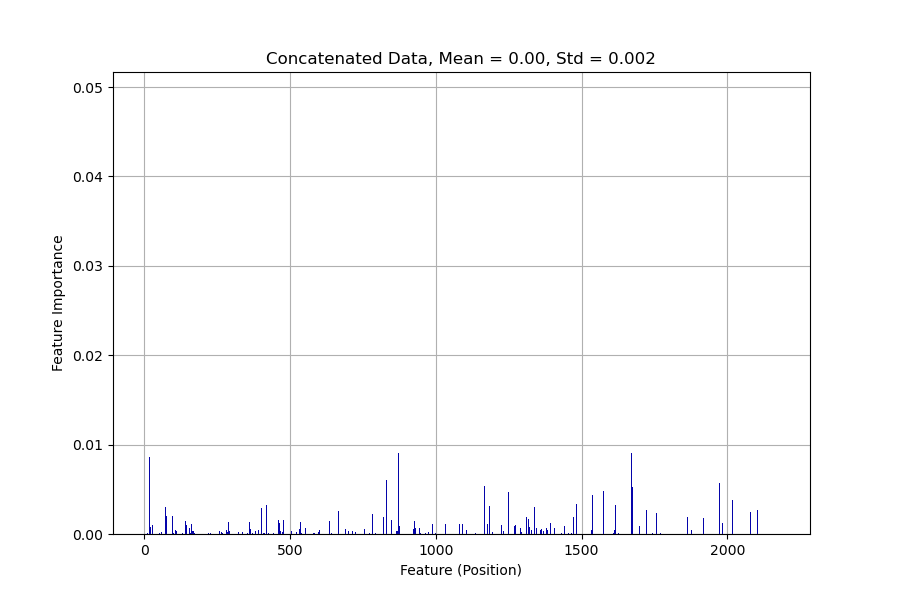

In [9]:
# Display the saved feature importance plots in the notebook
trainer.display_feature_importance_plots('XGB_Pos_Imp_Figs')

## De-Concatenate Data to Position Importance Values For Each Window Size

In [10]:
import pandas as pd
import os

# Define paths
input_file_path = 'XGB_Position_Importance_Values/feature_importances_concatenated.csv'
output_folder_path = 'XGB_Position_Importance_Deconcat'

# Ensure output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Read the concatenated feature importance values
df = pd.read_csv(input_file_path)

# Initial positions
start_pos = 0

for window_size in range(2, 52):
    # Calculate the number of positions for this window size (decreasing by 1 for each window)
    num_positions = 70 - window_size
    
    # Calculate start and end positions for slicing
    end_pos = start_pos + num_positions
    
    # Slice the dataframe for the current window size
    sliced_df = df.iloc[start_pos:end_pos].copy()
    
    # Renumber positions starting from 1
    sliced_df['Position'] = range(1, num_positions + 1)
    
    # Generate output file name
    output_file_name = f'feature_imp_deconcatenated_{window_size}.csv'
    output_file_path = os.path.join(output_folder_path, output_file_name)
    
    # Save to CSV
    sliced_df.to_csv(output_file_path, index=False)
    
    # Update start_pos for the next iteration
    start_pos = end_pos

print("De-concatenation process completed.")


De-concatenation process completed.


## Compare Multiples to Match Deconcatenated Importance Values to Unconcatenated

- Window size position variation
    - (70-window_size)/68
- Number of positions:
    - Sum of importances = 1
    - Multiply deconcatenated importances by 50
- Tuning accuracy for unconcat:
    - XGB_Tuning/XGB_Tuning_Trial_1/tuning_results.json

In [11]:
import pandas as pd
import os

# Base folder paths
folder_path_1 = 'XGB_Position_Importance_Deconcat'
folder_path_2 = 'XGB_Position_Importance_Values2'

# Loop through the window sizes
for window_size in range(2, 52):
    # File paths
    file_path_1 = os.path.join(folder_path_1, f'feature_imp_deconcatenated_{window_size}.csv')
    file_path_2 = os.path.join(folder_path_2, f'feature_importances_window_{window_size}.csv')
    
    # Read the CSV files
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)
    
    # Assuming the positions are in the first column and importances in the second
    position_col = df1.columns[0]
    importance_col = df1.columns[1]
    
    # Calculate the differences in importance values
    differences = df1[importance_col] - df2[importance_col]
    
    # Optionally, save or print the differences
    # Here, we'll just print the average difference for simplicity
    print(f"Average difference for window size {window_size}: {differences.abs().mean()}")


Average difference for window size 2: 0.014083504195991177
Average difference for window size 3: 0.01424569456742836
Average difference for window size 4: 0.014595590521833334
Average difference for window size 5: 0.014990254044230768
Average difference for window size 6: 0.014866117332328125
Average difference for window size 7: 0.015480575668952378
Average difference for window size 8: 0.015789387819129034
Average difference for window size 9: 0.015976098647065572
Average difference for window size 10: 0.015928648341899998
Average difference for window size 11: 0.016477298490661013
Average difference for window size 12: 0.0167043654947931
Average difference for window size 13: 0.017188109222992982
Average difference for window size 14: 0.016400995354291074
Average difference for window size 15: 0.01769024691241818
Average difference for window size 16: 0.018021003821555557
Average difference for window size 17: 0.01860241823509434
Average difference for window size 18: 0.018784655161

In [12]:
import pandas as pd
import os

# Base folder paths
folder_path_1 = 'XGB_Position_Importance_Deconcat'
folder_path_2 = 'XGB_Position_Importance_Values2'

# Loop through the window sizes
for window_size in range(2, 52):
    # File paths
    file_path_1 = os.path.join(folder_path_1, f'feature_imp_deconcatenated_{window_size}.csv')
    file_path_2 = os.path.join(folder_path_2, f'feature_importances_window_{window_size}.csv')
    
    # Read the CSV files
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)
    
    # Assuming the positions are in the first column and importances in the second
    position_col = df1.columns[0]
    importance_col = df1.columns[1]
    
    # Multiply importance values in df1 by 50
    df2[importance_col] = df2[importance_col] * 50
    
    # Calculate the differences in importance values
    differences = df1[importance_col] - df2[importance_col]
    
    # Optionally, save or print the differences
    # Here, we'll just print the average difference for simplicity
    print(f"Average difference for window size {window_size}: {differences.abs().mean()}")


Average difference for window size 2: 0.7346717239974617
Average difference for window size 3: 0.7455889741271298
Average difference for window size 4: 0.7570198486854696
Average difference for window size 5: 0.7688363769826924
Average difference for window size 6: 0.7804910642745155
Average difference for window size 7: 0.7928541190340317
Average difference for window size 8: 0.8061120439400967
Average difference for window size 9: 0.8192474420749344
Average difference for window size 10: 0.8325338449952332
Average difference for window size 11: 0.8469857283855763
Average difference for window size 12: 0.8615006754827241
Average difference for window size 13: 0.8767877204580806
Average difference for window size 14: 0.8914010399792911
Average difference for window size 15: 0.9085993540360544
Average difference for window size 16: 0.9254285158530371
Average difference for window size 17: 0.9431307399067925
Average difference for window size 18: 0.9610924019347309
Average difference for

In [13]:
import pandas as pd
import os

# Base folder paths
folder_path_1 = 'XGB_Position_Importance_Deconcat'
folder_path_2 = 'XGB_Position_Importance_Values2'

# Loop through the window sizes
for window_size in range(2, 52):
    # File paths
    file_path_1 = os.path.join(folder_path_1, f'feature_imp_deconcatenated_{window_size}.csv')
    file_path_2 = os.path.join(folder_path_2, f'feature_importances_window_{window_size}.csv')
    
    # Read the CSV files
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)
    
    # Assuming the positions are in the first column and importances in the second
    position_col = df1.columns[0]
    importance_col = df1.columns[1]
    
    # Multiply importance values in df1 by 50
    df2[importance_col] = df2[importance_col] * 50
    df2[importance_col] = df2[importance_col] * ((70 - window_size)/68)
    
    # Calculate the differences in importance values
    differences = df1[importance_col] - df2[importance_col]
    
    print(f"Average difference for window size {window_size}: {differences.abs().mean()}")


Average difference for window size 2: 0.7346717239974617
Average difference for window size 3: 0.7346144351181308
Average difference for window size 4: 0.7347382082844003
Average difference for window size 5: 0.7348997267903846
Average difference for window size 6: 0.7345351851063171
Average difference for window size 7: 0.7344974445475706
Average difference for window size 8: 0.7349545418883889
Average difference for window size 9: 0.7348694271990908
Average difference for window size 10: 0.7344946195050372
Average difference for window size 11: 0.7348222249483878
Average difference for window size 12: 0.7347258378686268
Average difference for window size 13: 0.7348888466242313
Average difference for window size 14: 0.7338380067334926
Average difference for window size 15: 0.7348025594291028
Average difference for window size 16: 0.7347966855943224
Average difference for window size 17: 0.7350286266853715
Average difference for window size 18: 0.734848044966405
Average difference for 

# RMSE

In [14]:
import pandas as pd
import os
import numpy as np  

# Base folder paths
folder_path_1 = 'XGB_Position_Importance_Deconcat'
folder_path_2 = 'XGB_Position_Importance_Values2'

# Loop through the window sizes
for window_size in range(2, 52):
    # File paths
    file_path_1 = os.path.join(folder_path_1, f'feature_imp_deconcatenated_{window_size}.csv')
    file_path_2 = os.path.join(folder_path_2, f'feature_importances_window_{window_size}.csv')
    
    # Read the CSV files
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)
    
    # Assuming the positions are in the first column and importances in the second
    position_col = df1.columns[0]
    importance_col = df1.columns[1]
    
    # Adjust importance values in df1 as per your instructions (It seems there was a mistake in your instructions, you applied the modifications to df2 instead of df1)
    df1[importance_col] = df1[importance_col] * 50 * ((70 - window_size) / 68)

    # Calculate squared differences
    squared_differences = (df1[importance_col] - df2[importance_col]) ** 2

    # Compute mean of squared differences
    mean_squared_difference = np.mean(squared_differences)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_difference)

    print(f"RMSE for window size {window_size}: {rmse}")


RMSE for window size 2: 0.06444233908557052
RMSE for window size 3: 0.06023295274514394
RMSE for window size 4: 0.04760595737018489
RMSE for window size 5: 0.03858970199149513
RMSE for window size 6: 0.07912632420638821
RMSE for window size 7: 0.12940142250648187
RMSE for window size 8: 0.03876980137216644
RMSE for window size 9: 0.04130048488581527
RMSE for window size 10: 0.08785825080393424
RMSE for window size 11: 0.045648713560517154
RMSE for window size 12: 0.05046676710904546
RMSE for window size 13: 0.07333532104508304
RMSE for window size 14: 0.2415459562478153
RMSE for window size 15: 0.043665052443432974
RMSE for window size 16: 0.06119241487153302
RMSE for window size 17: 0.030512241677933927
RMSE for window size 18: 0.05982220873273495
RMSE for window size 19: 0.026851541438353447
RMSE for window size 20: 0.04398230898905672
RMSE for window size 21: 0.03862780843502582
RMSE for window size 22: 0.04677431870536865
RMSE for window size 23: 0.07447419666935985
RMSE for window

## Graphical representation of feature importances

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Create the output directory if it doesn't exist
output_dir = "Overlaid_Importance"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

folder_path_1 = 'XGB_Position_Importance_Deconcat'
folder_path_2 = 'XGB_Position_Importance_Values2'
    
def adjust_and_plot(window_size):
    # Construct file paths
    unconcatenated_file = f"XGB_Position_Importance_Values2/feature_importances_window_{window_size}.csv"
    deconcatenated_file = f"XGB_Position_Importance_Deconcat/feature_imp_deconcatenated_{window_size}.csv"
    
    # Read the CSV Files
    df10 = pd.read_csv(unconcatenated_file)
    df20 = pd.read_csv(deconcatenated_file)
    
    # Assuming the positions are in the first column and importances in the second
    position_col = df10.columns[0]
    importance_col = df10.columns[1]
    
    # Multiply importance values in df1 by adjustment factor
    df20[importance_col] = df20[importance_col] * 50
#     df20[importance_col] = df20[importance_col] * ((70 - window_size)/68)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(df10['Position'], df10['Importance'], color='blue', label='Unconcatenated', alpha=0.6)
    plt.bar(df20['Position'], df20['Importance'], color='red', label='Deconcatenated', alpha=0.6)
    plt.title(f'Position Importance Values for Window Size {window_size}')
    plt.xlabel('Position')
    plt.ylabel('Importance')
    plt.legend()
    plt.savefig(f"Overlaid_Importance/Overlaid_Importance_{window_size}.png")
    plt.close()

# Loop through all window sizes
for window_size in range(2, 51):
    adjust_and_plot(window_size)

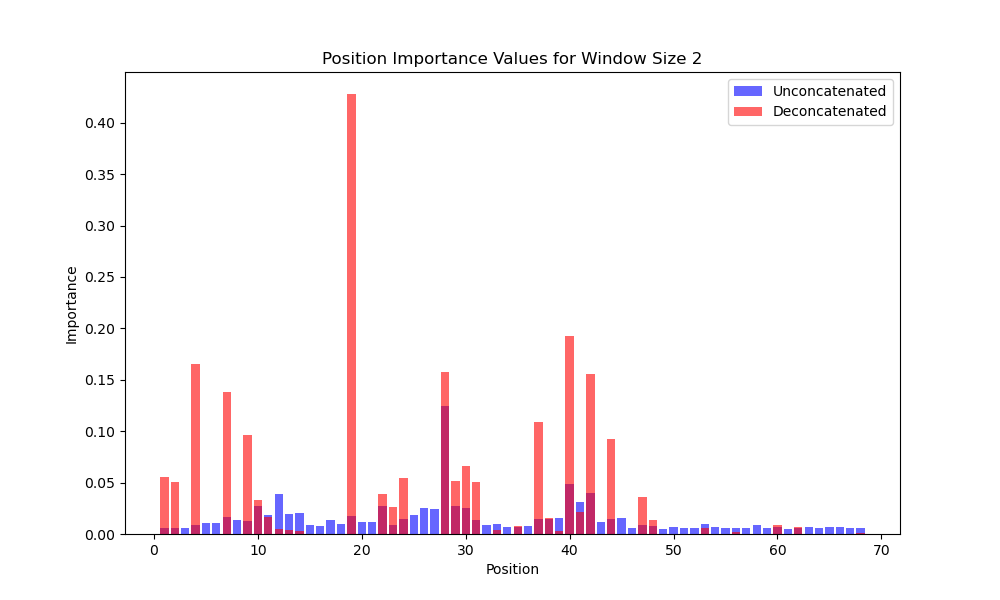

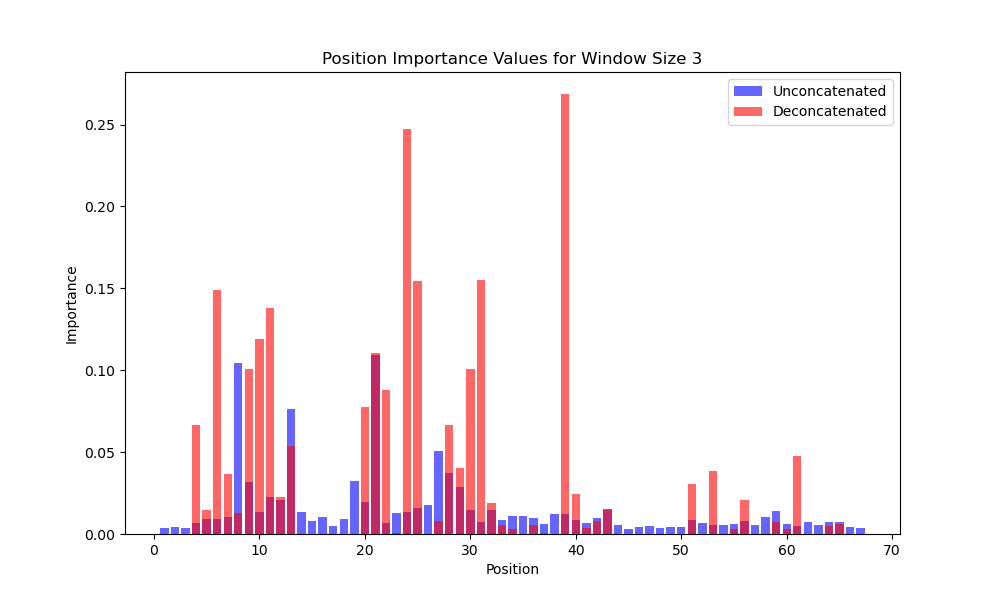

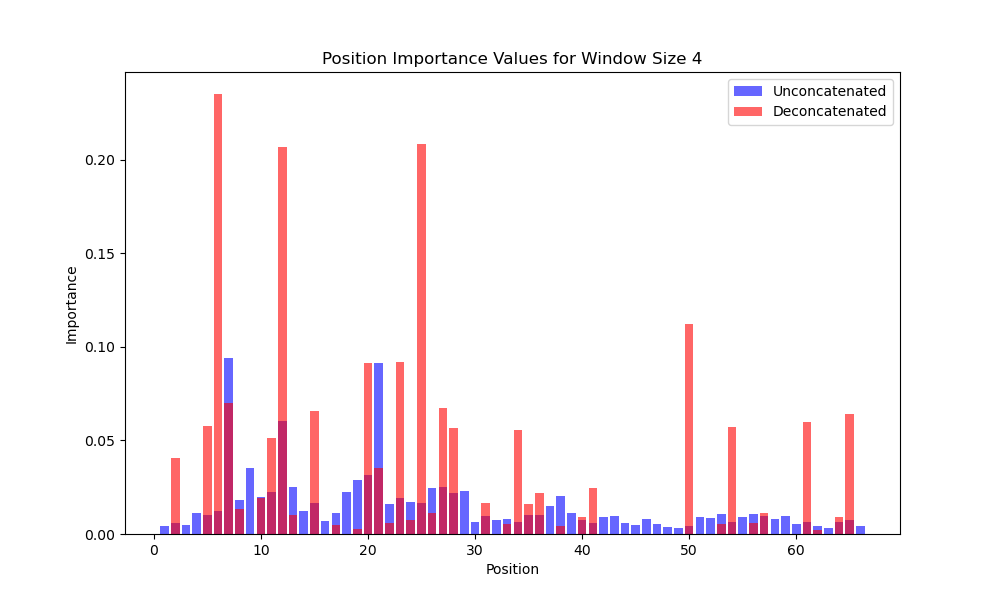

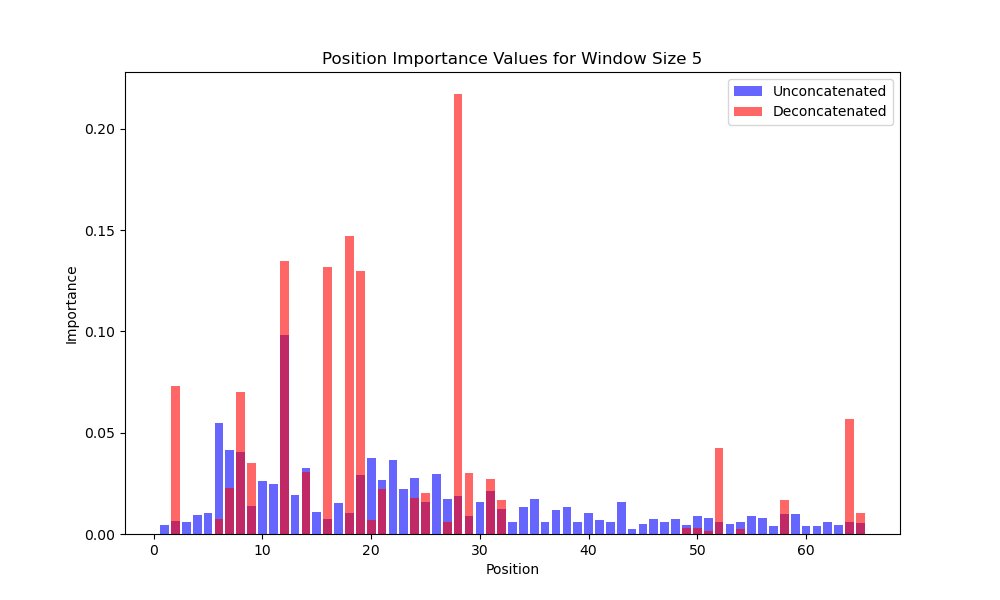

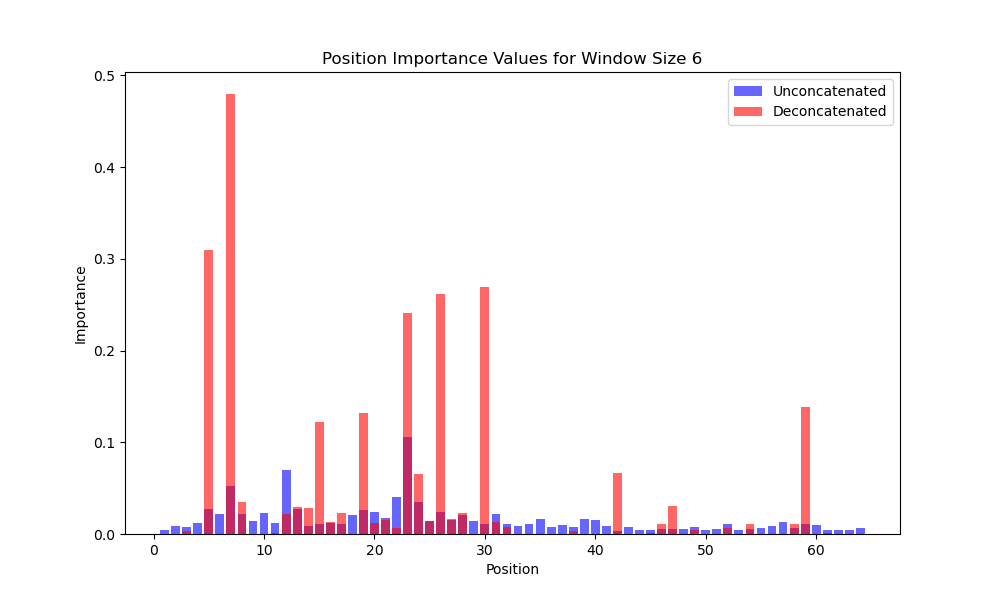

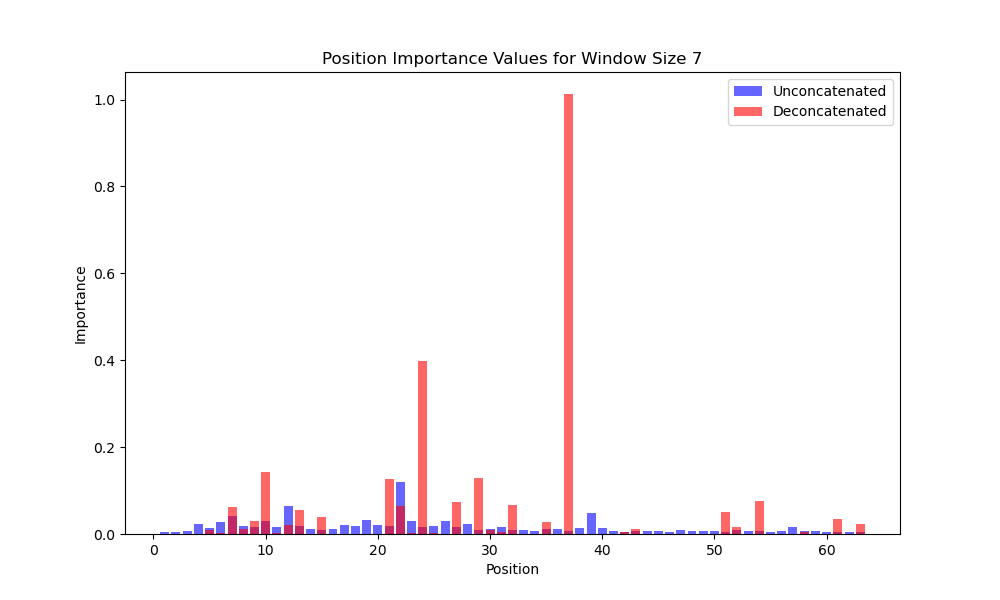

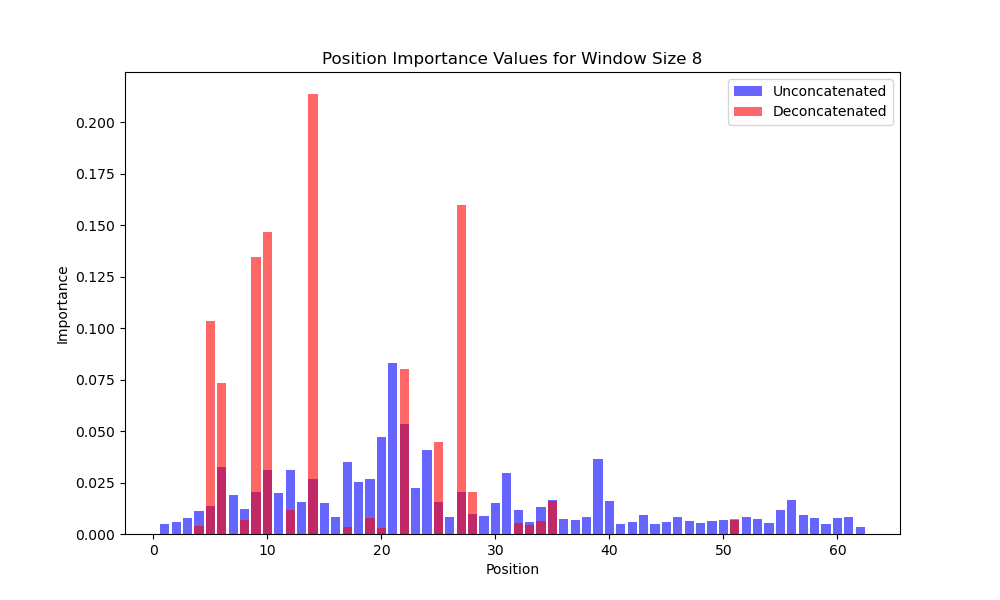

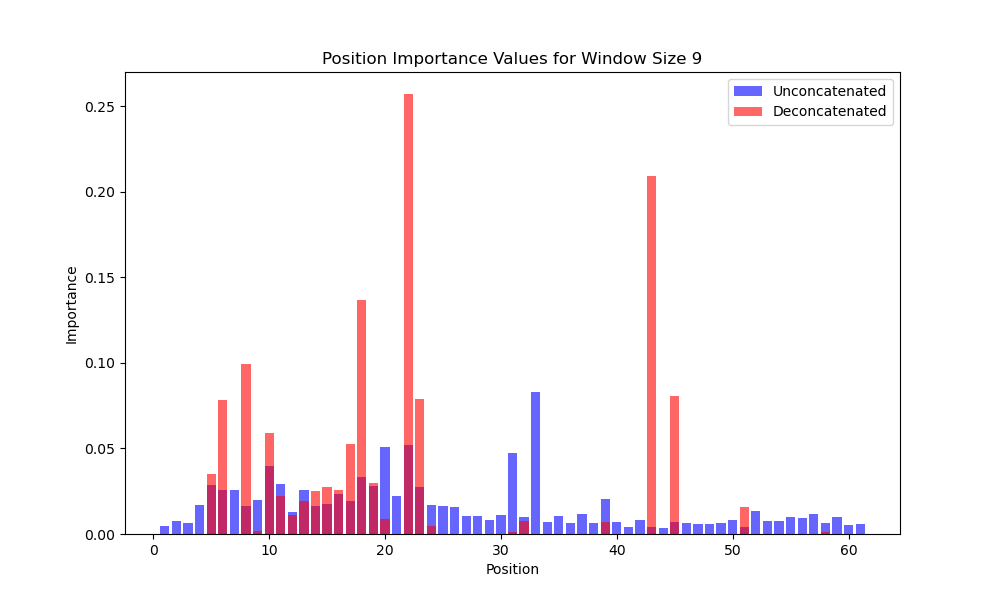

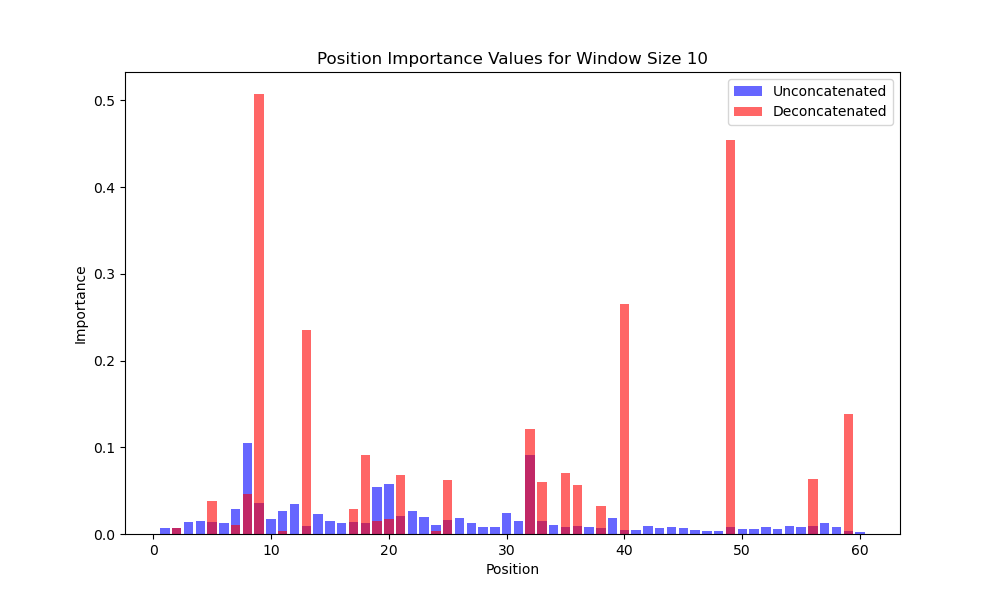

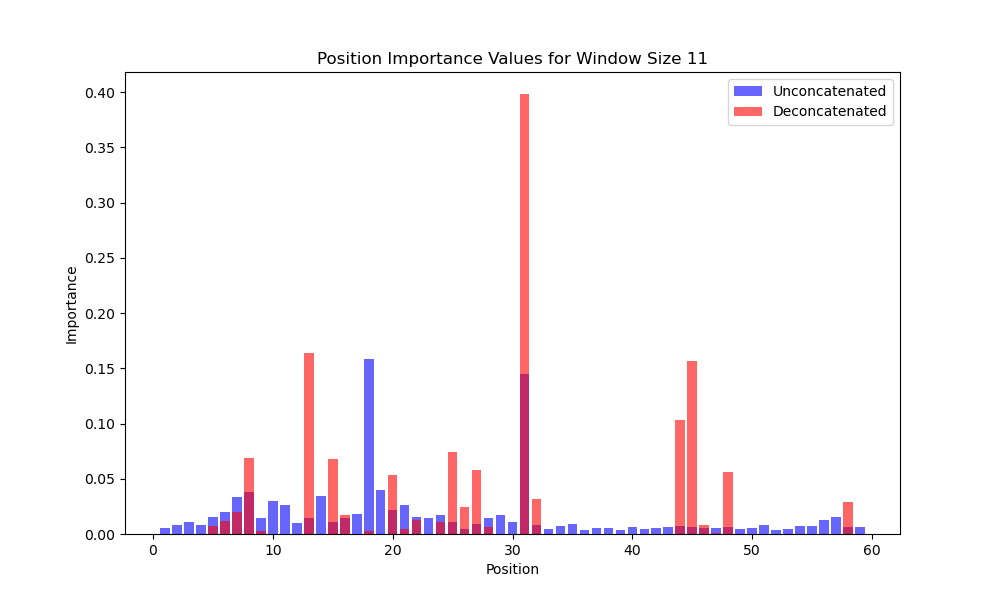

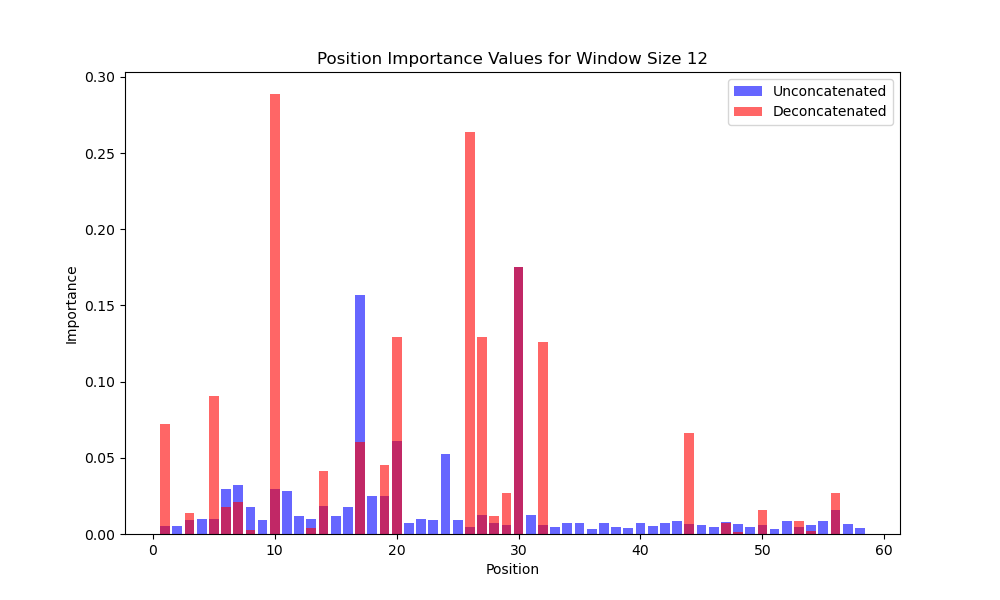

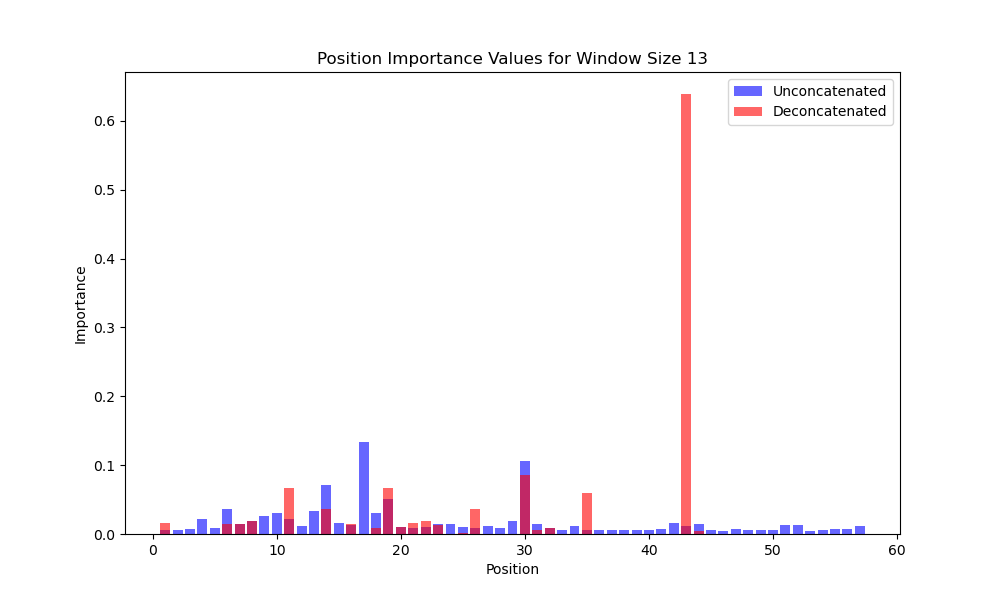

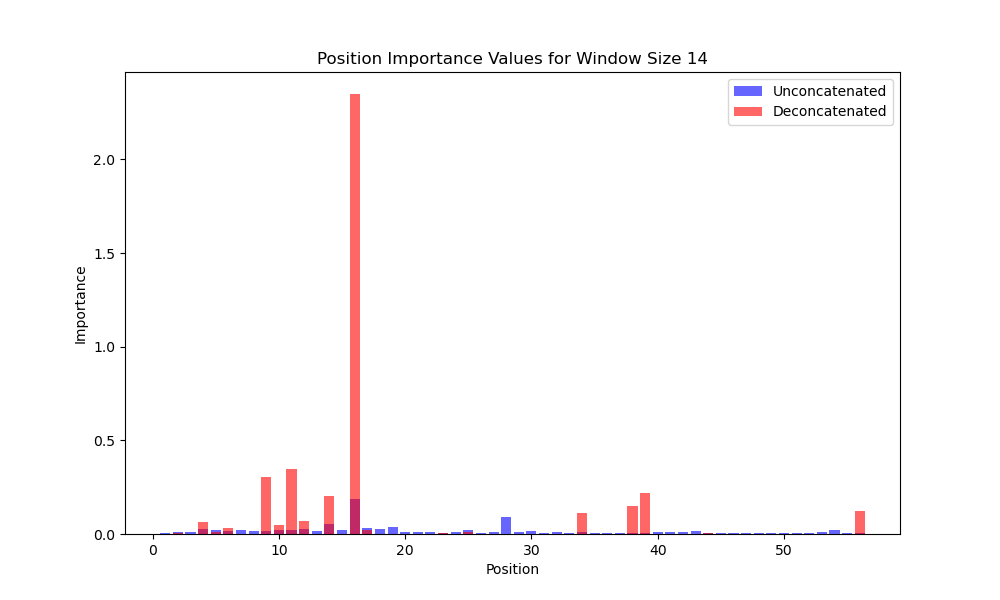

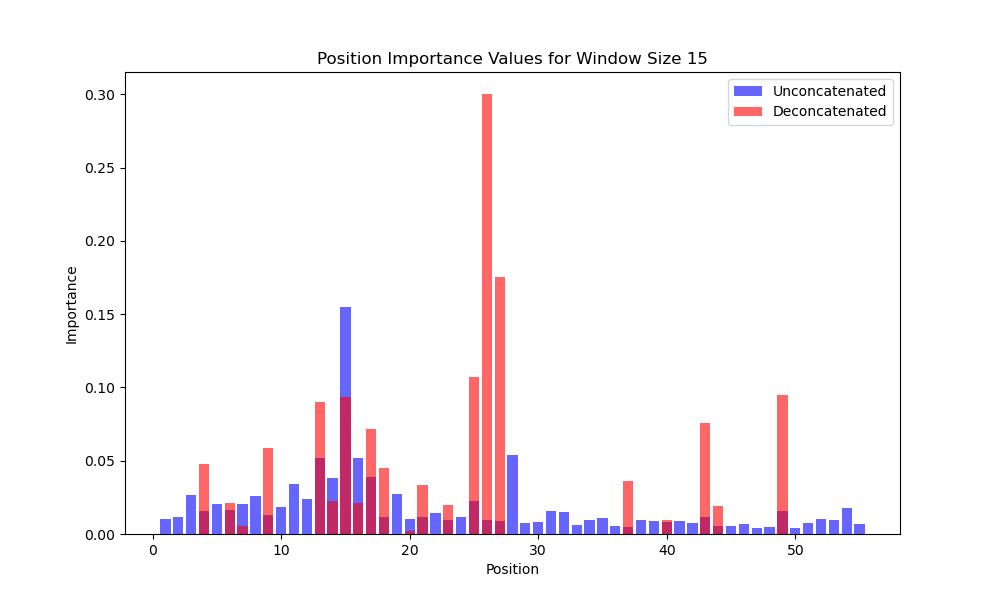

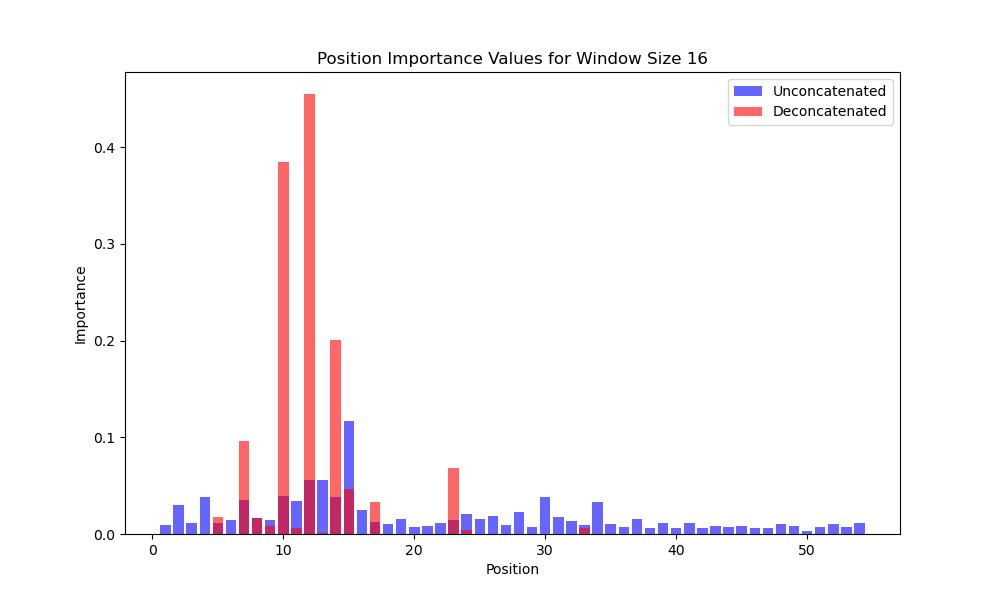

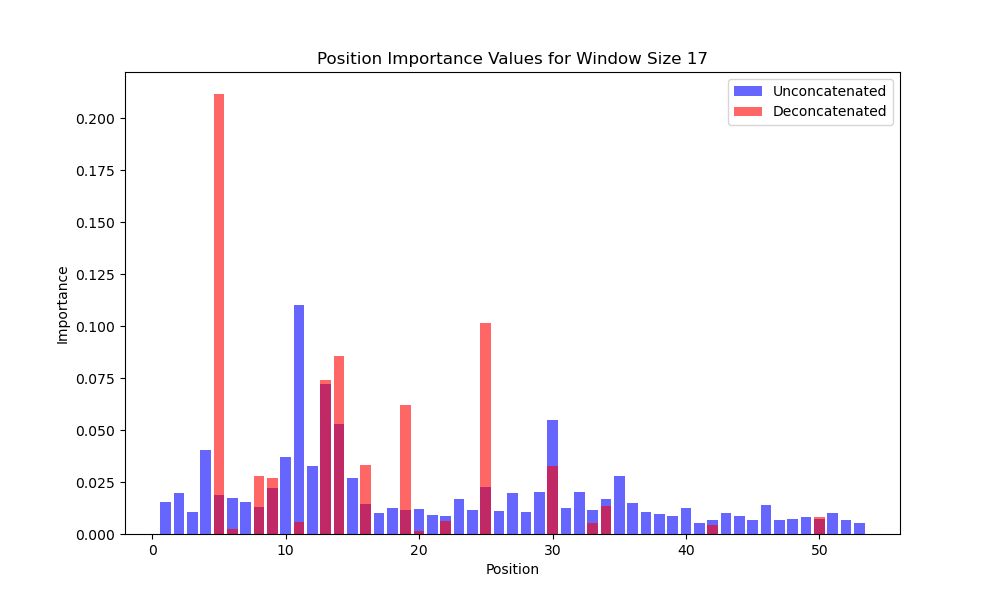

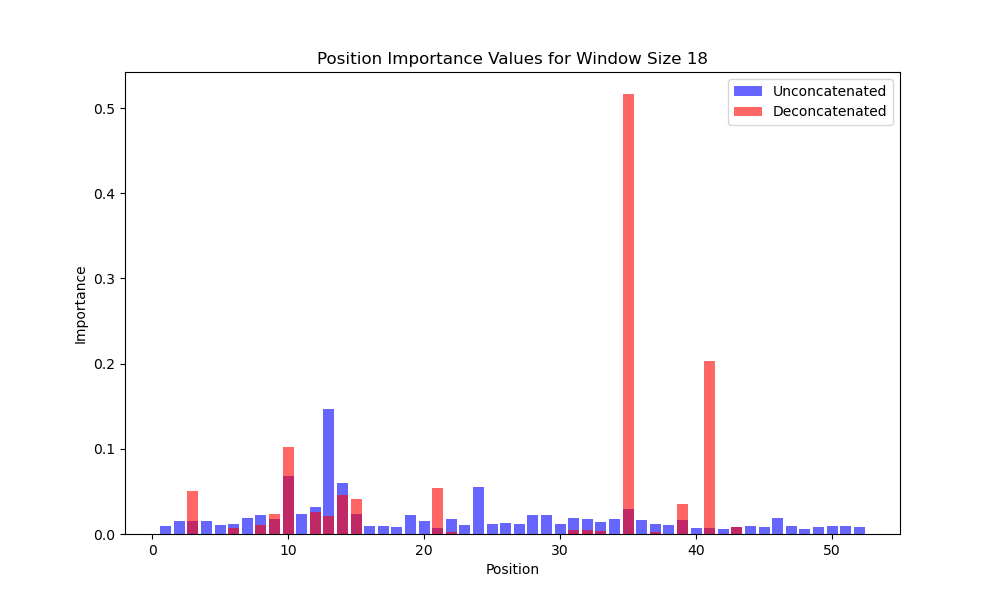

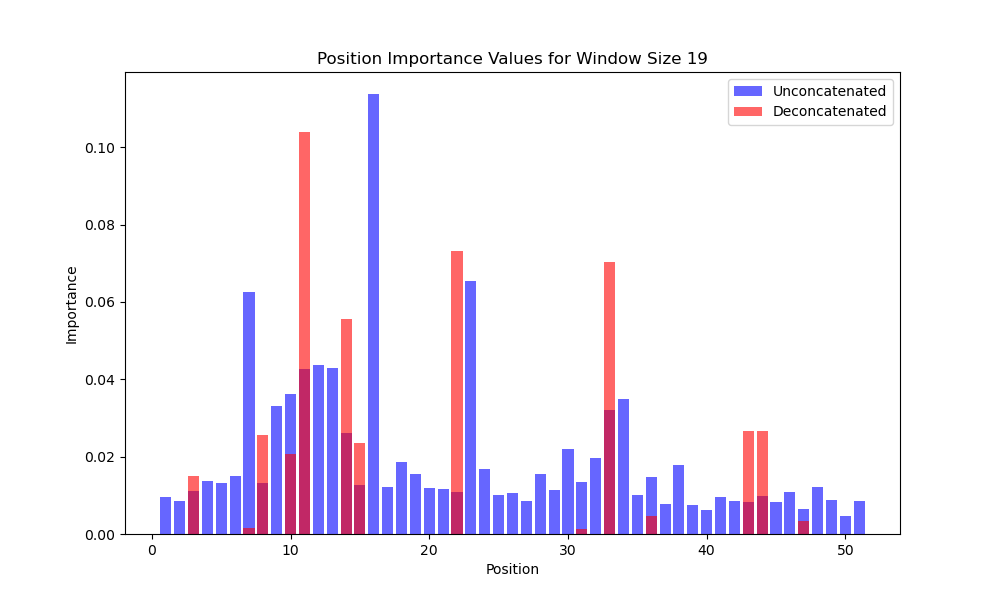

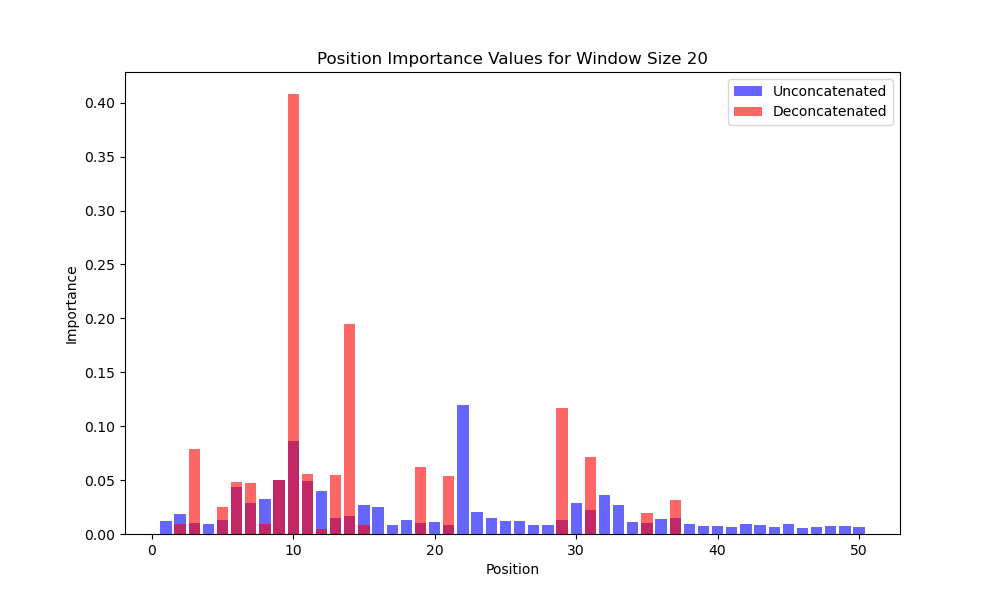

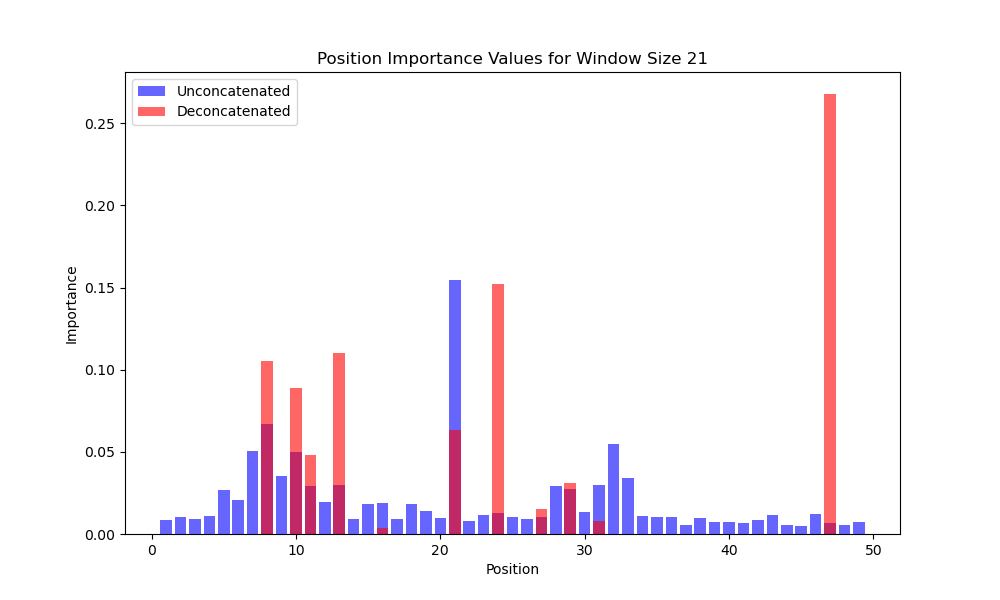

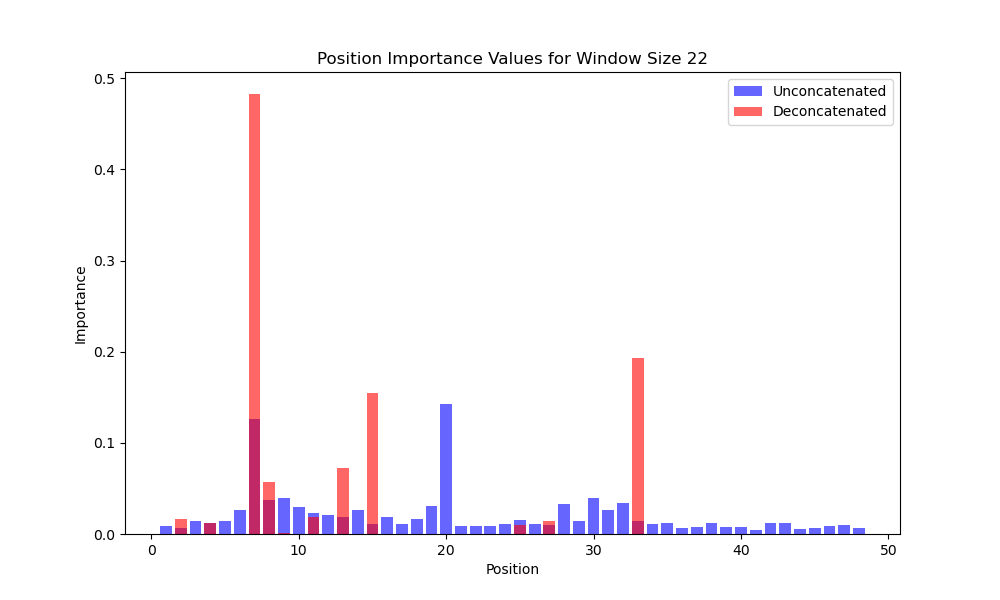

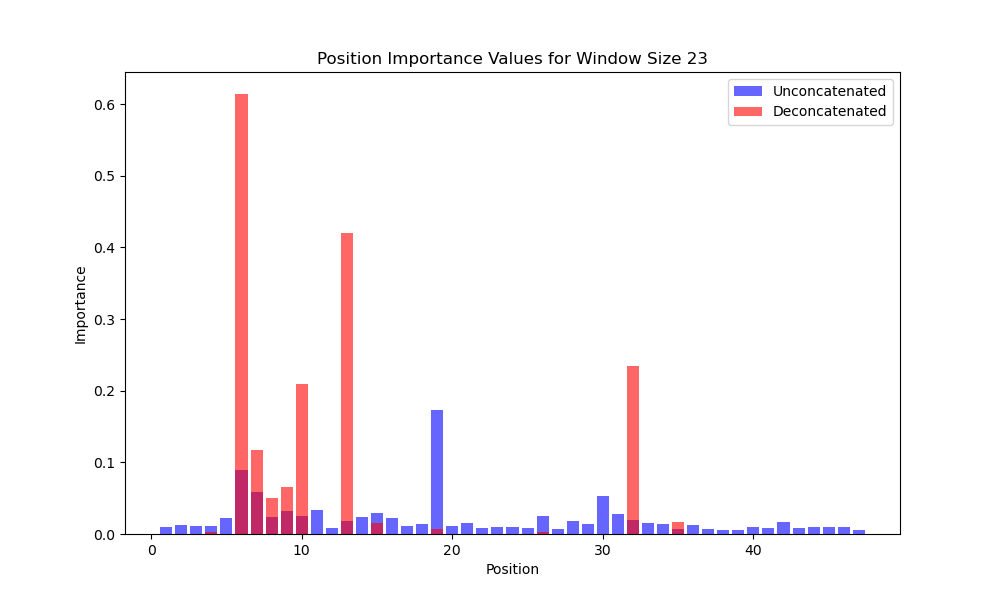

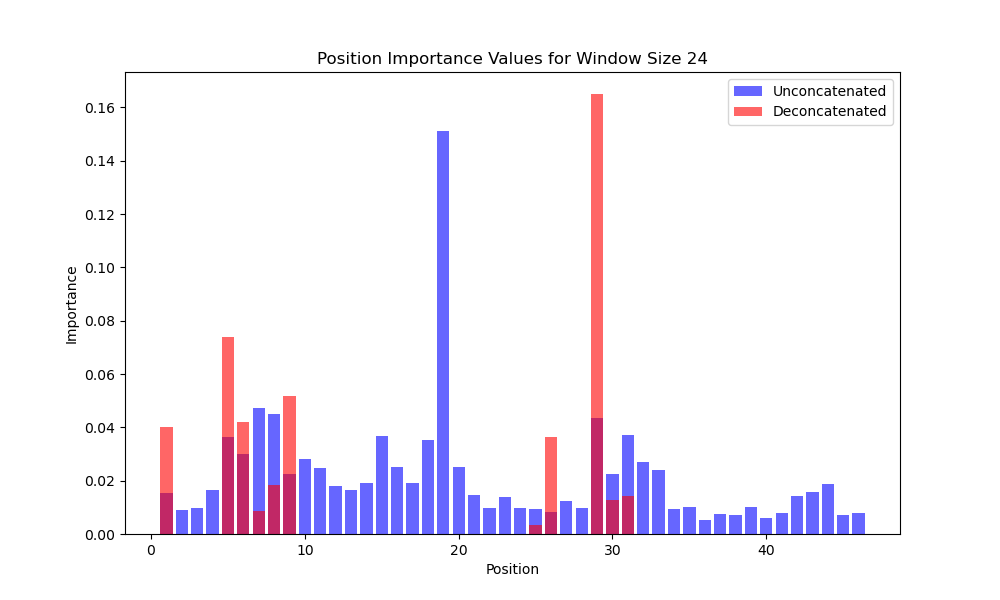

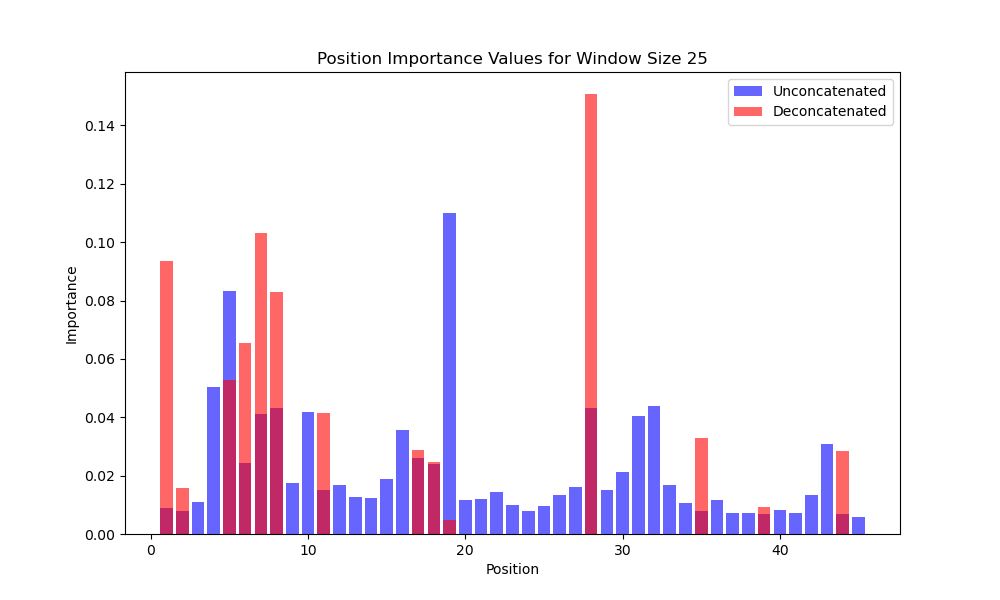

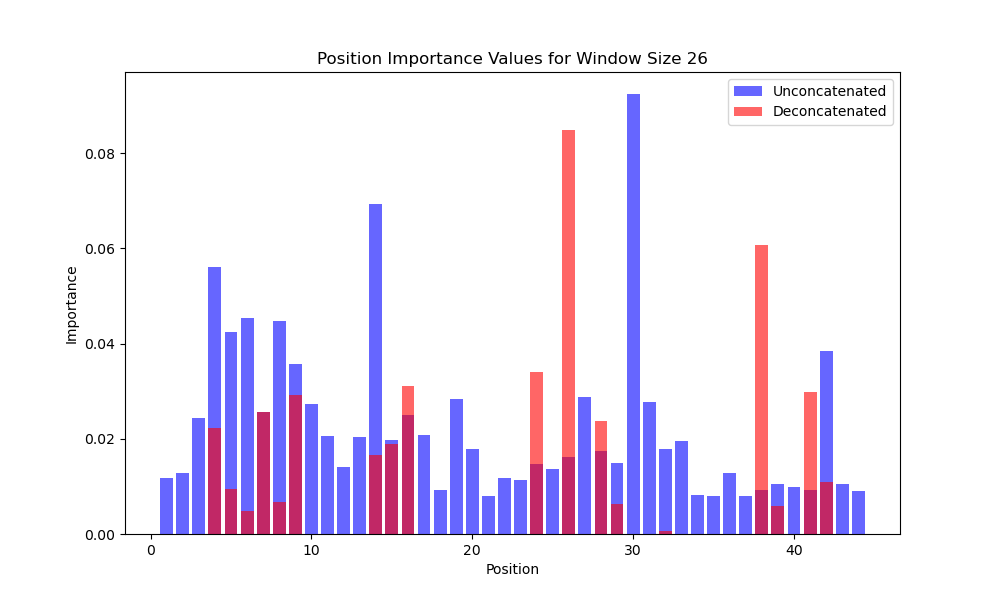

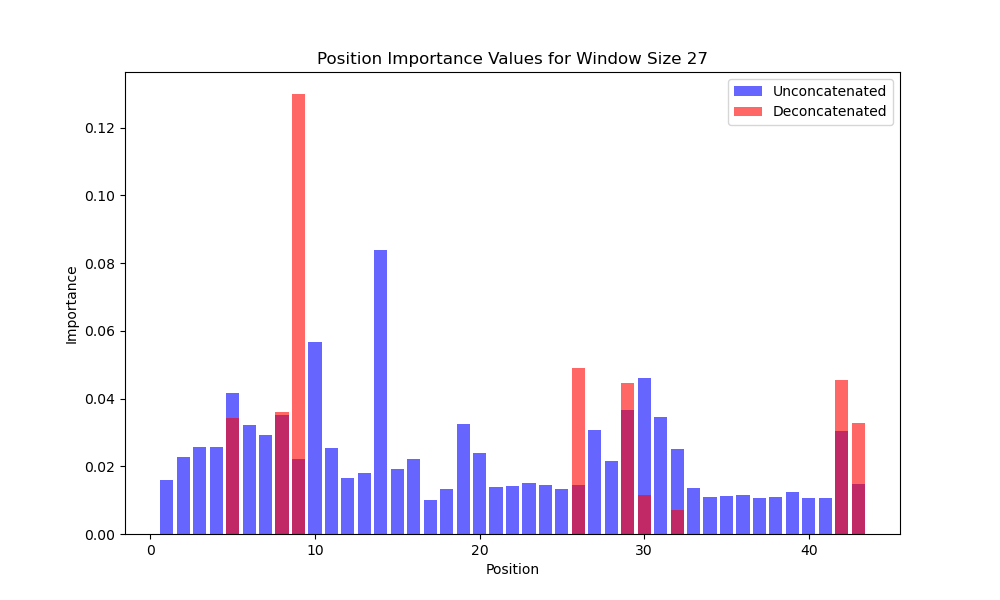

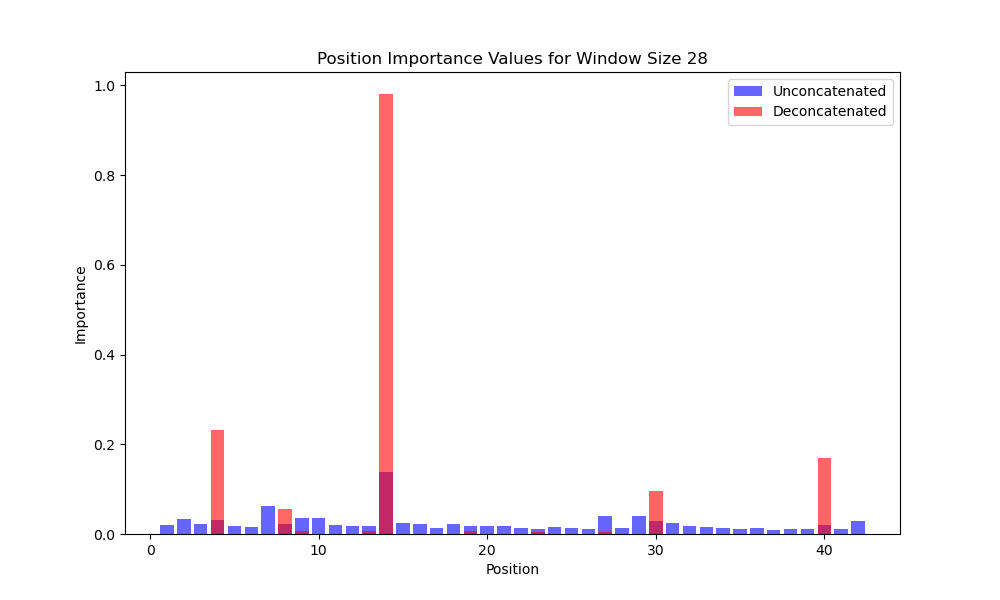

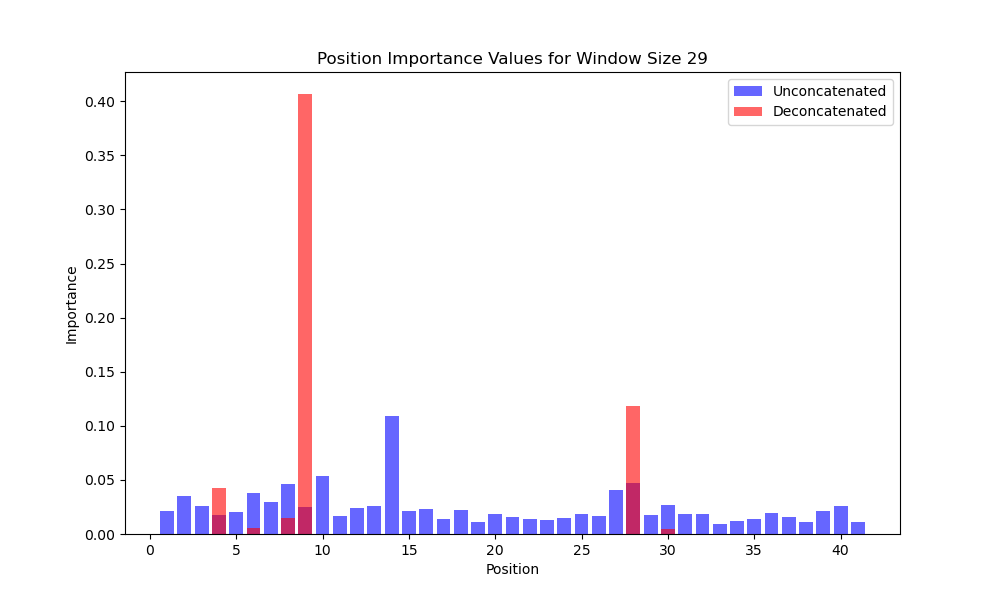

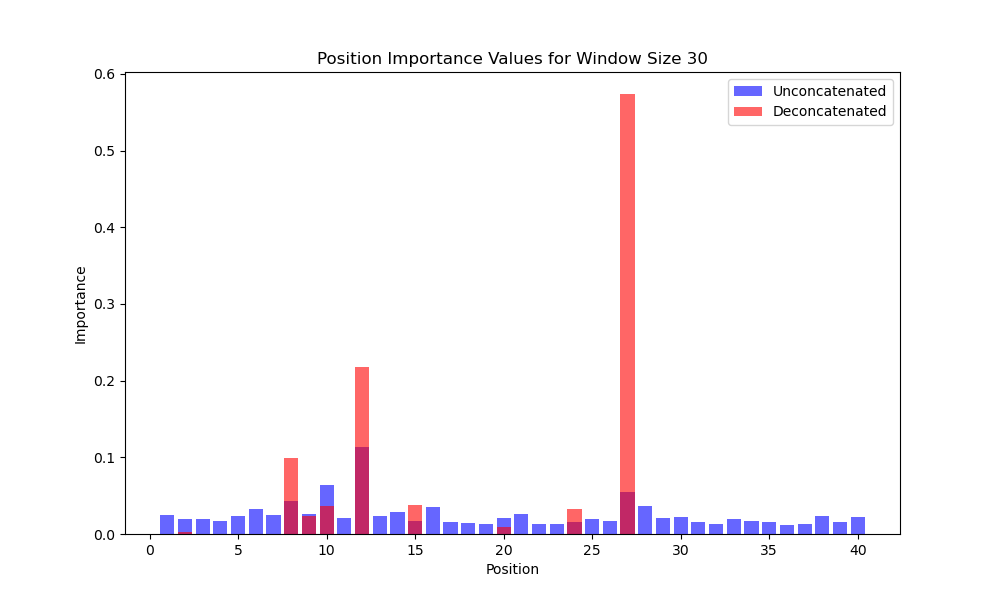

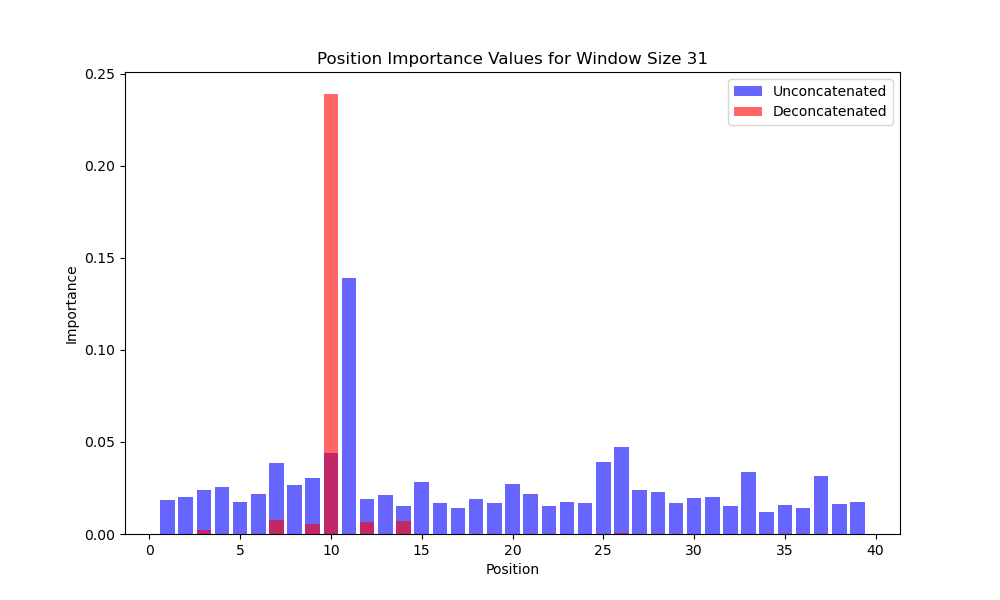

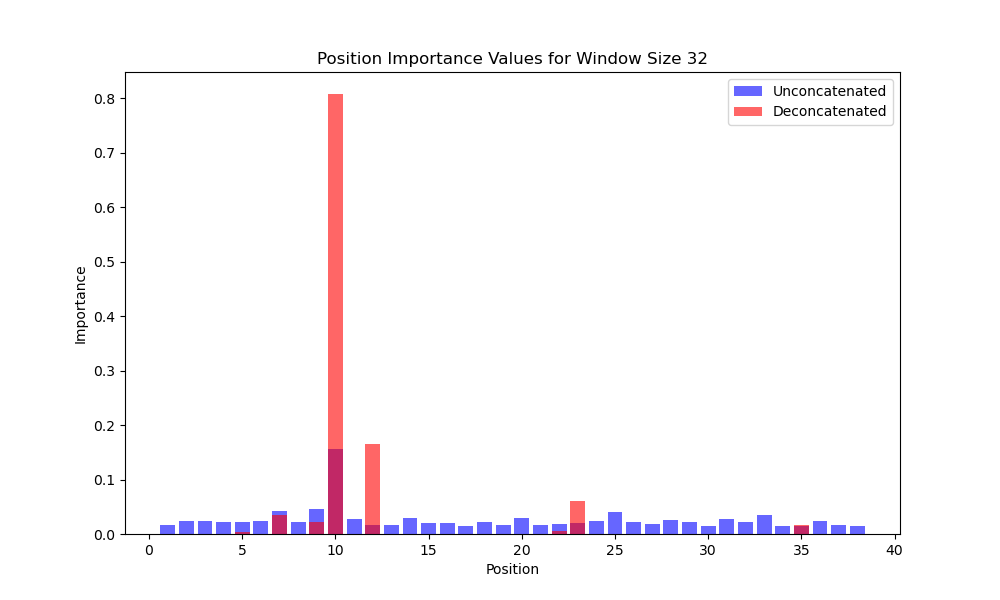

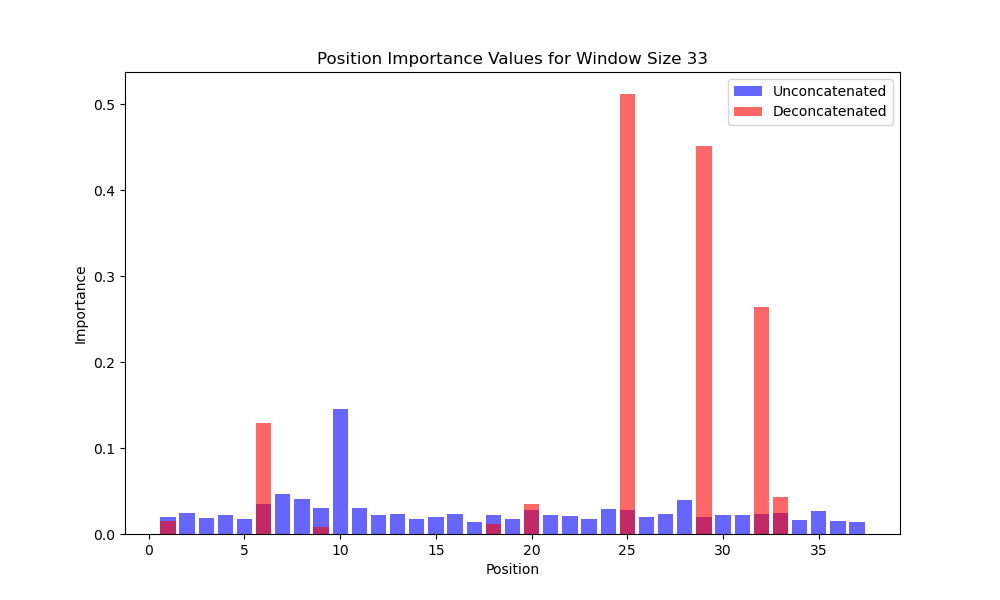

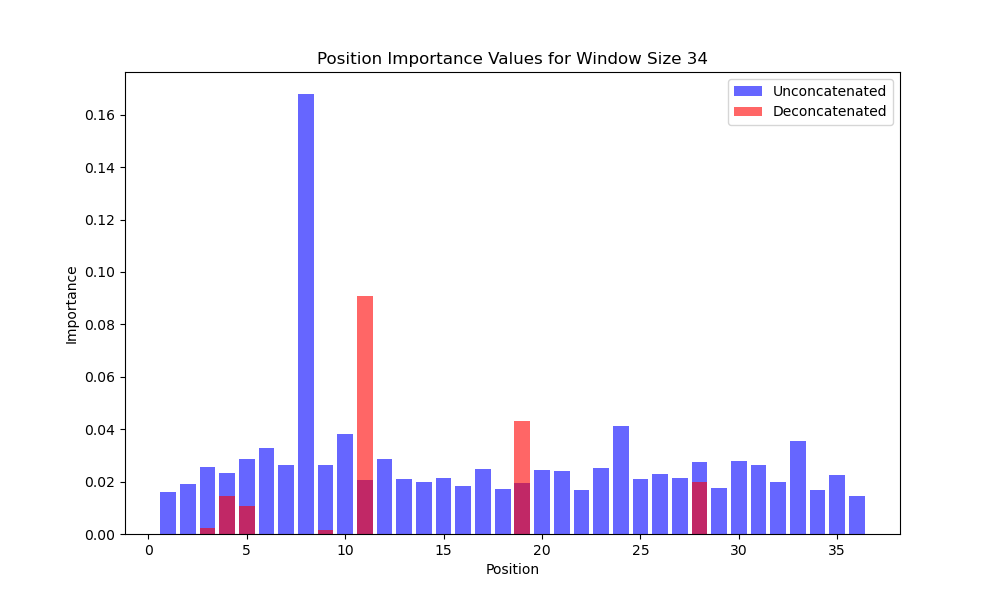

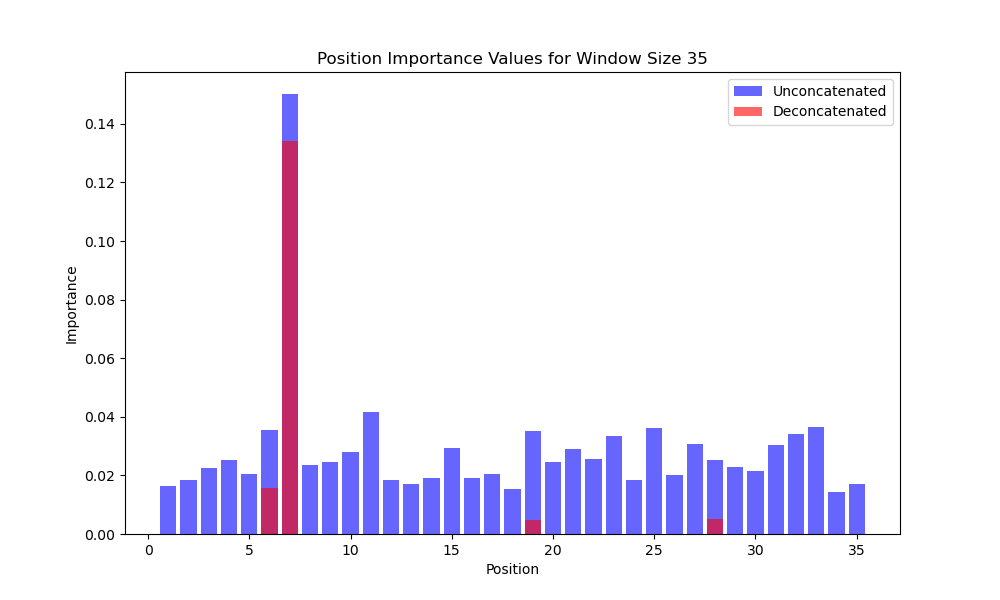

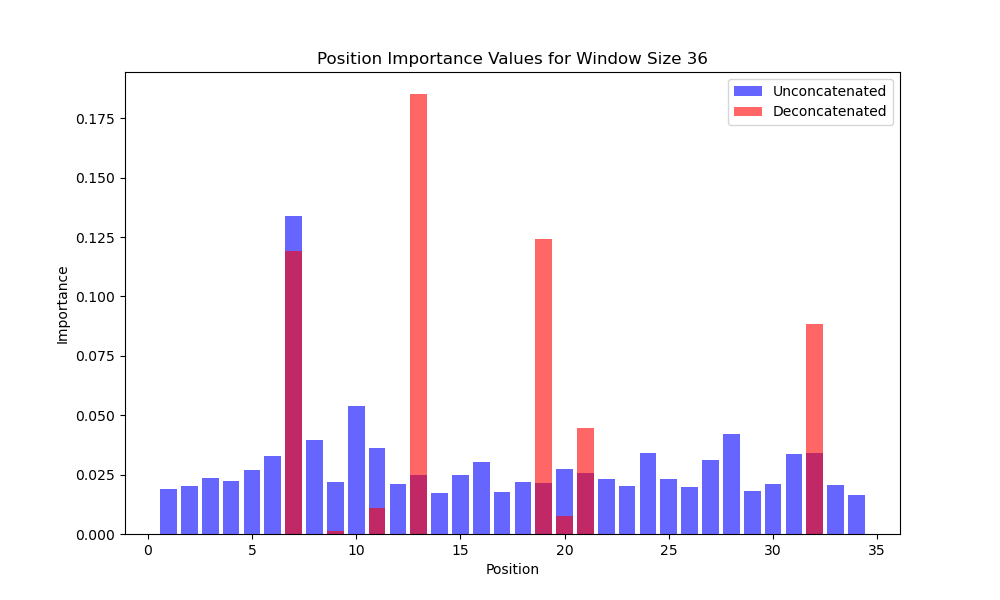

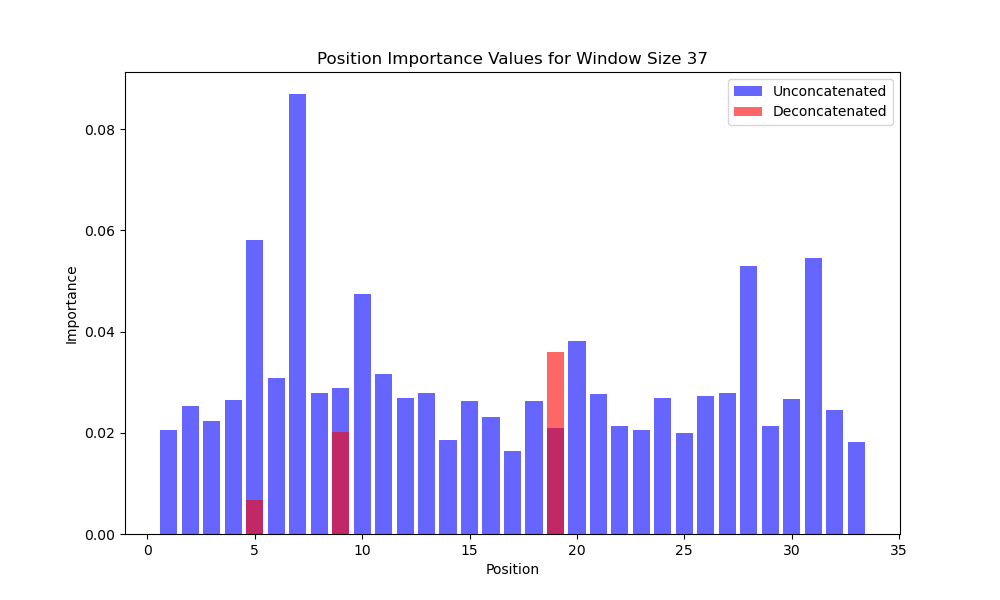

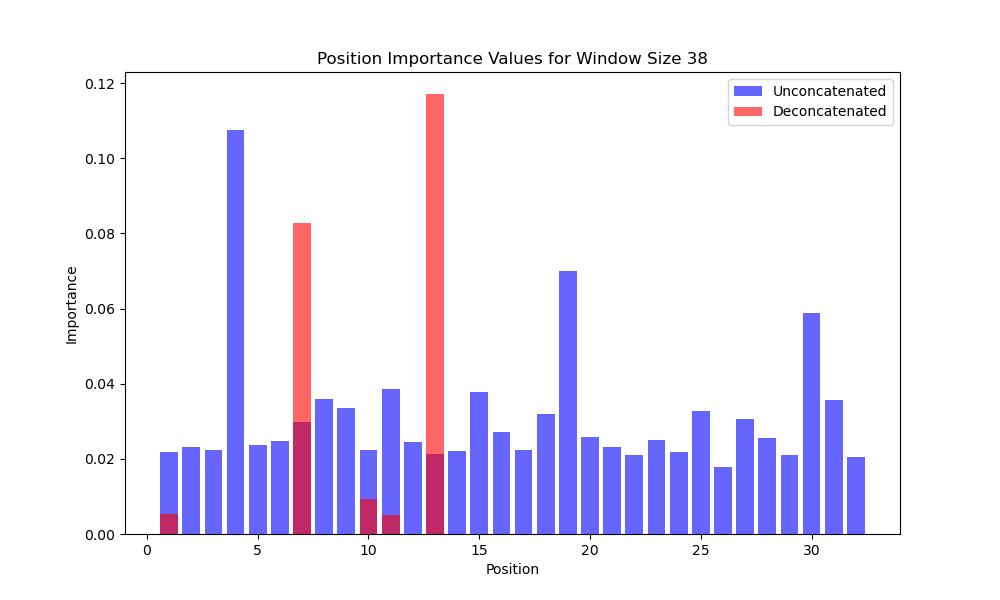

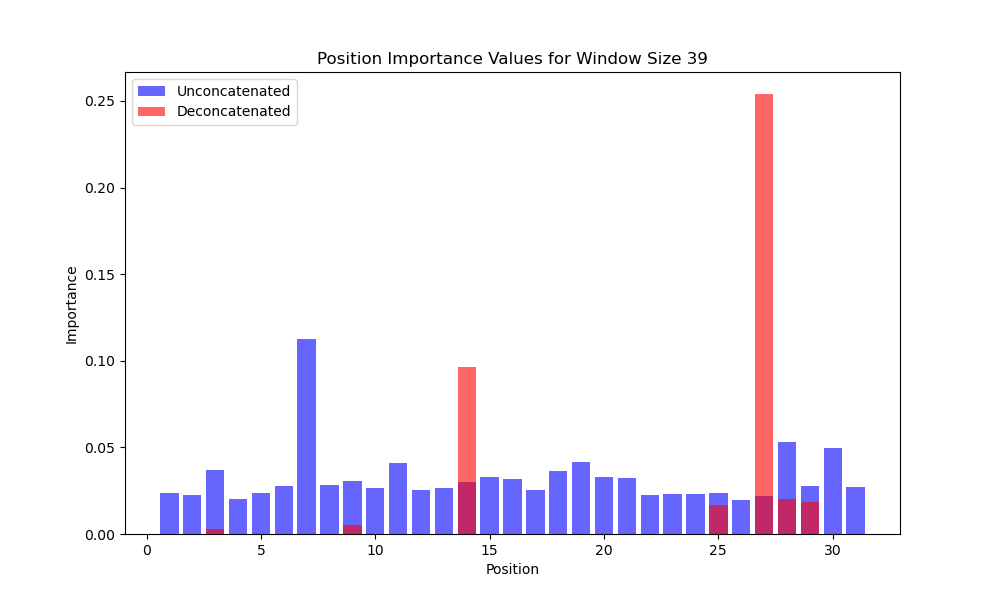

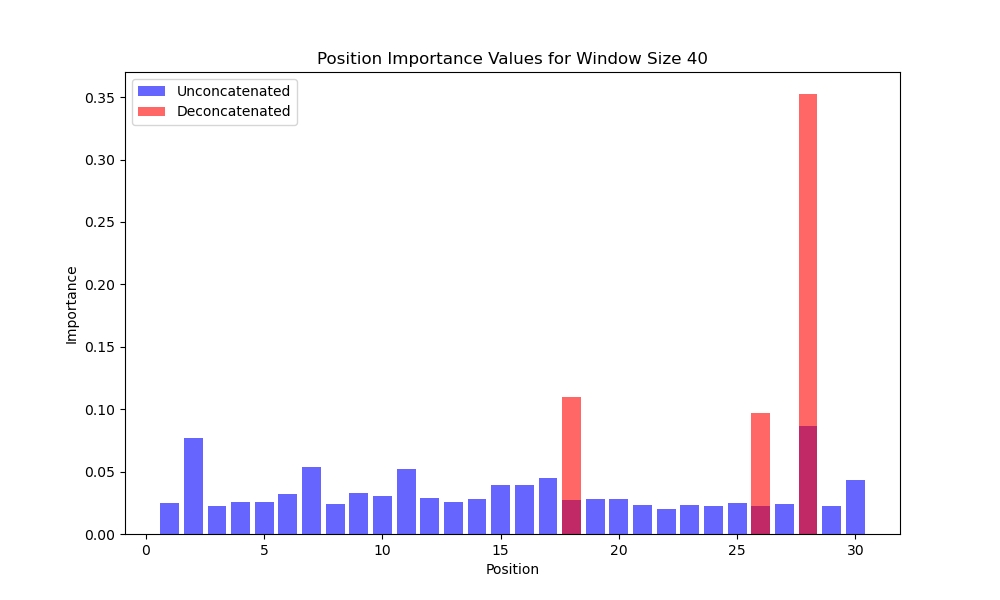

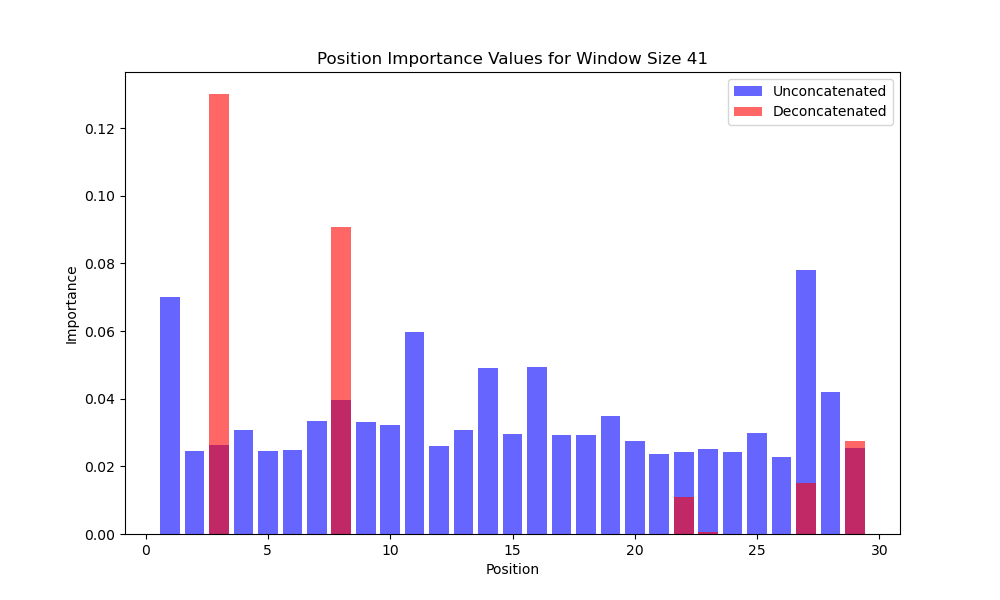

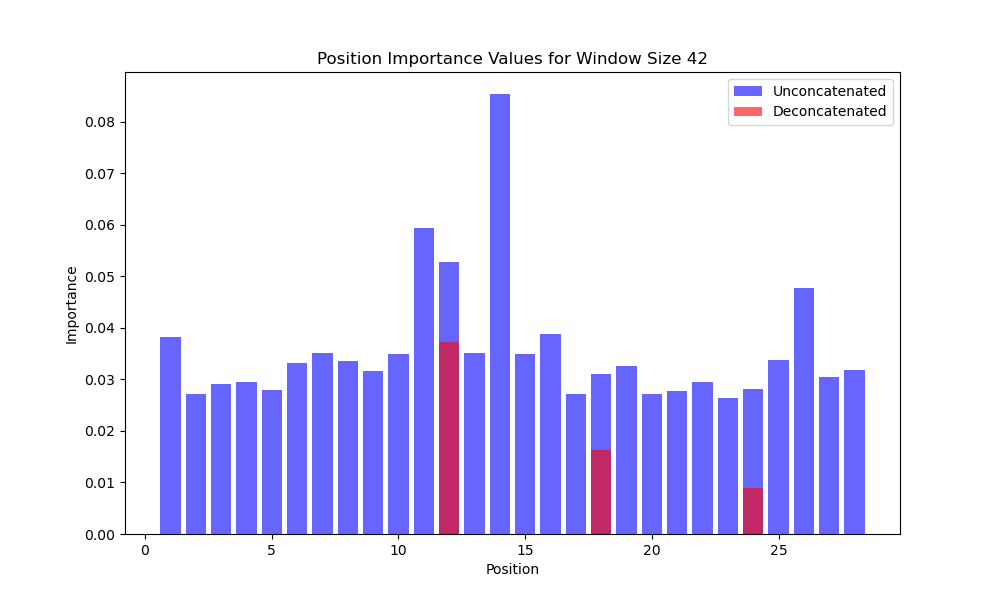

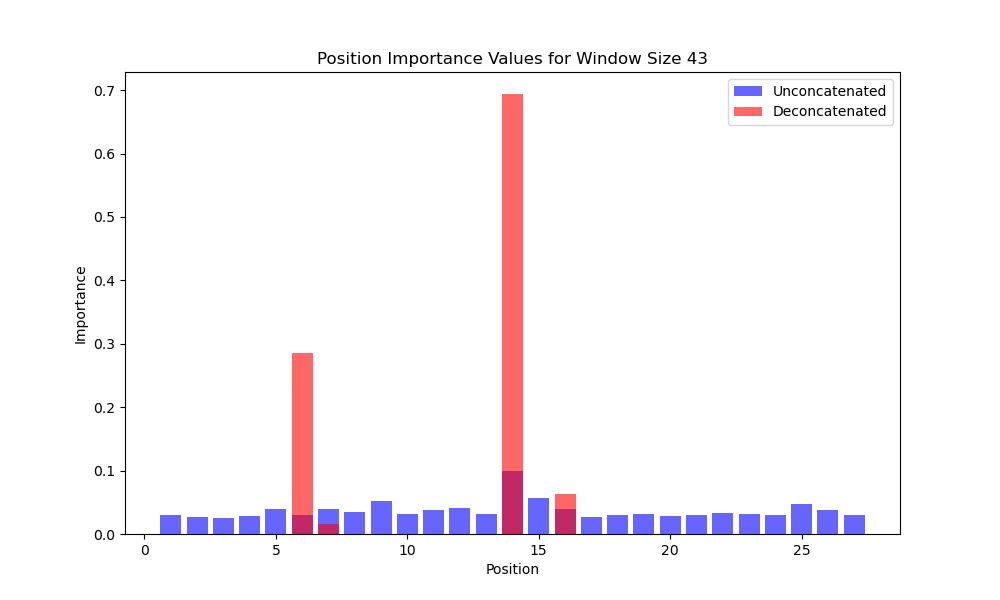

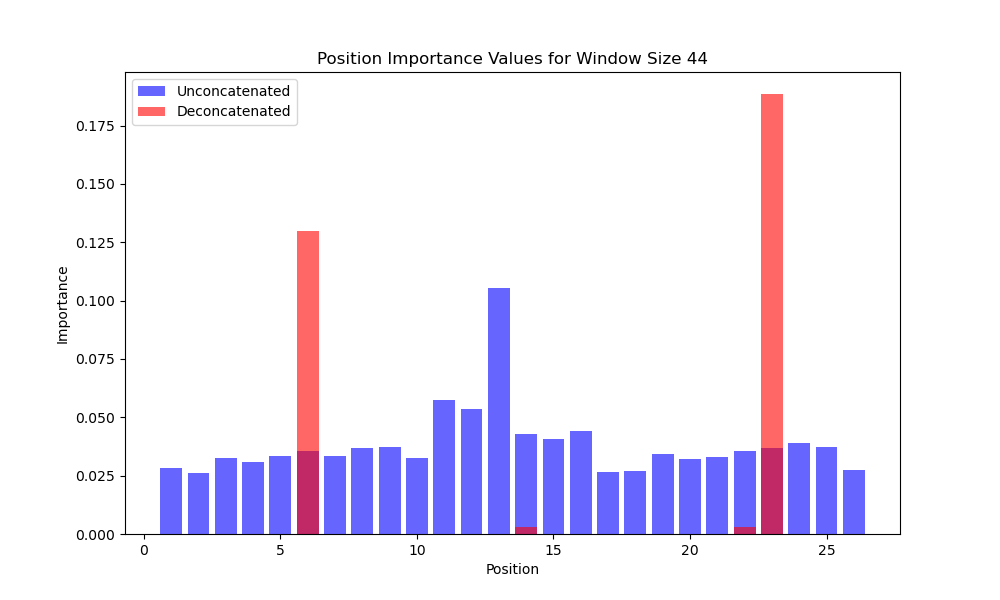

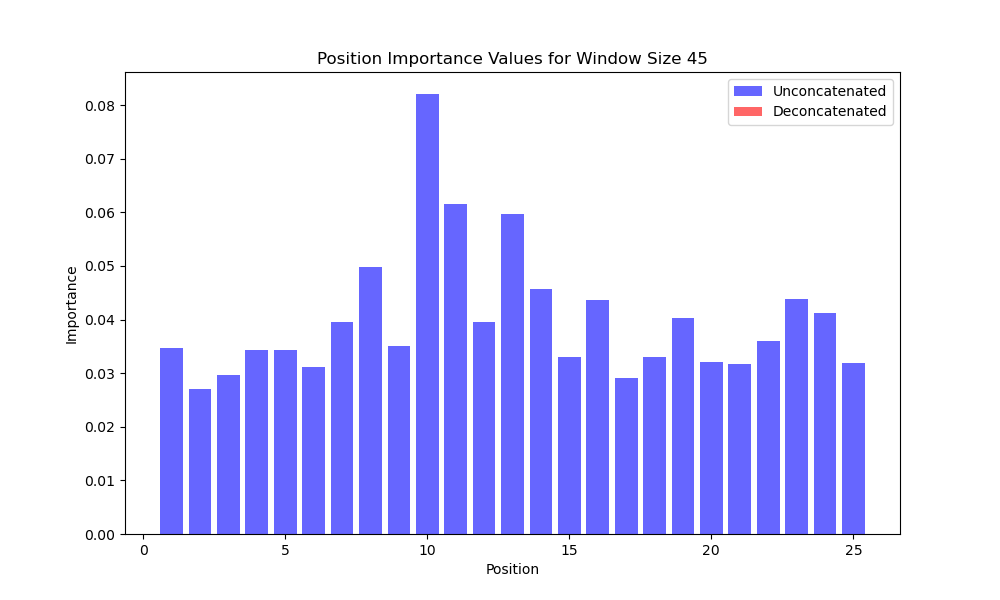

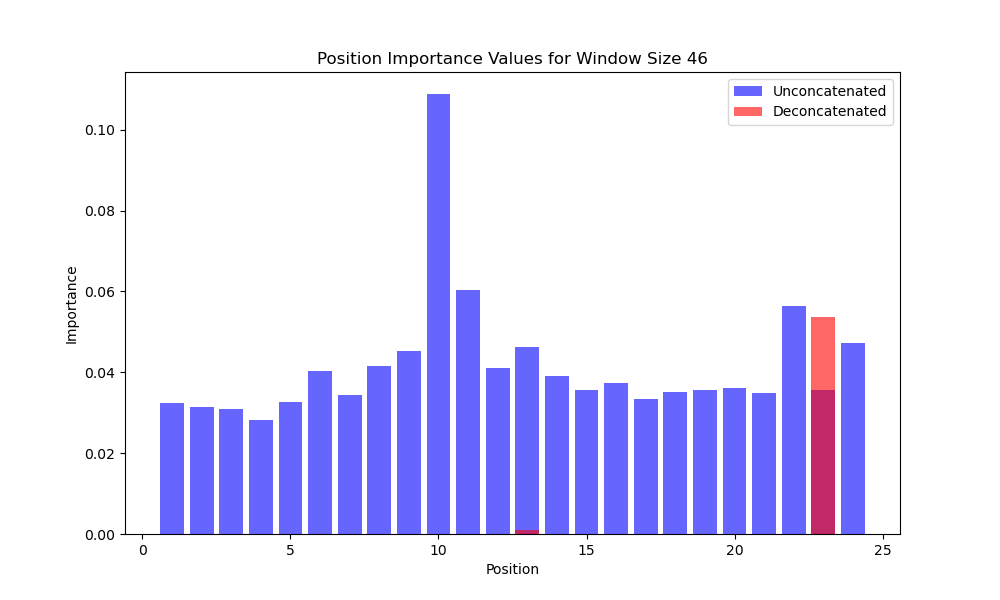

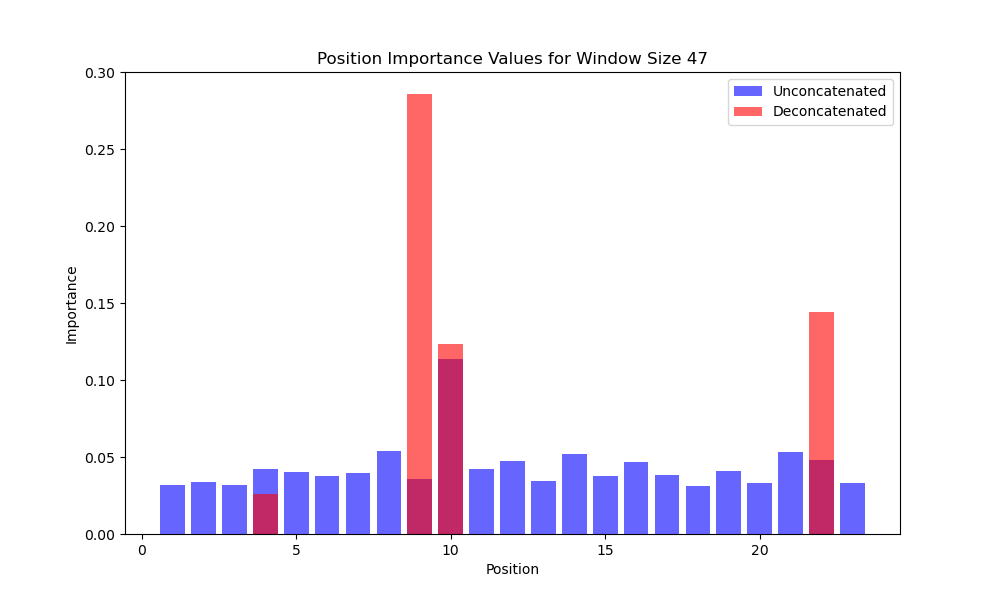

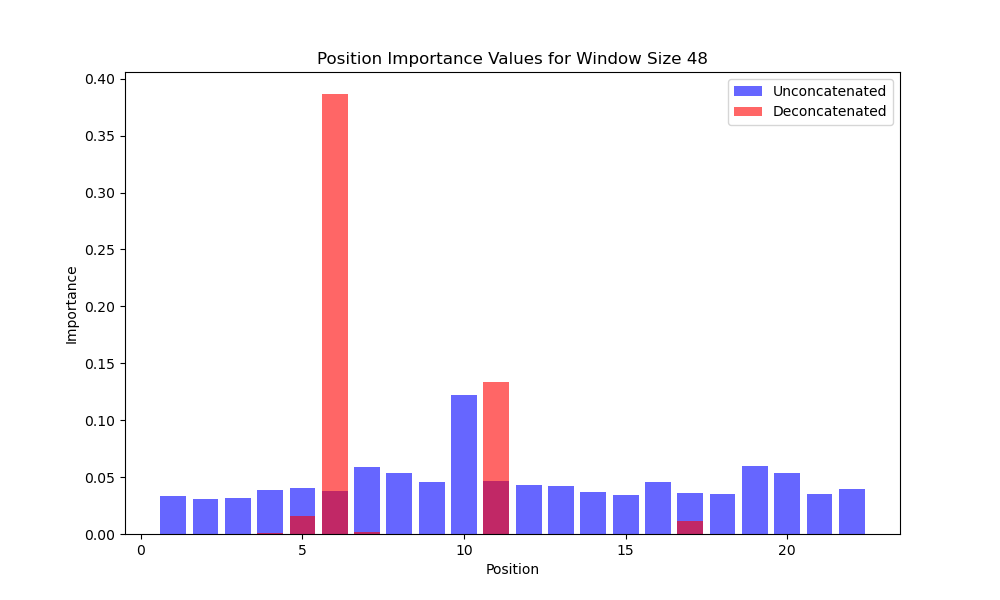

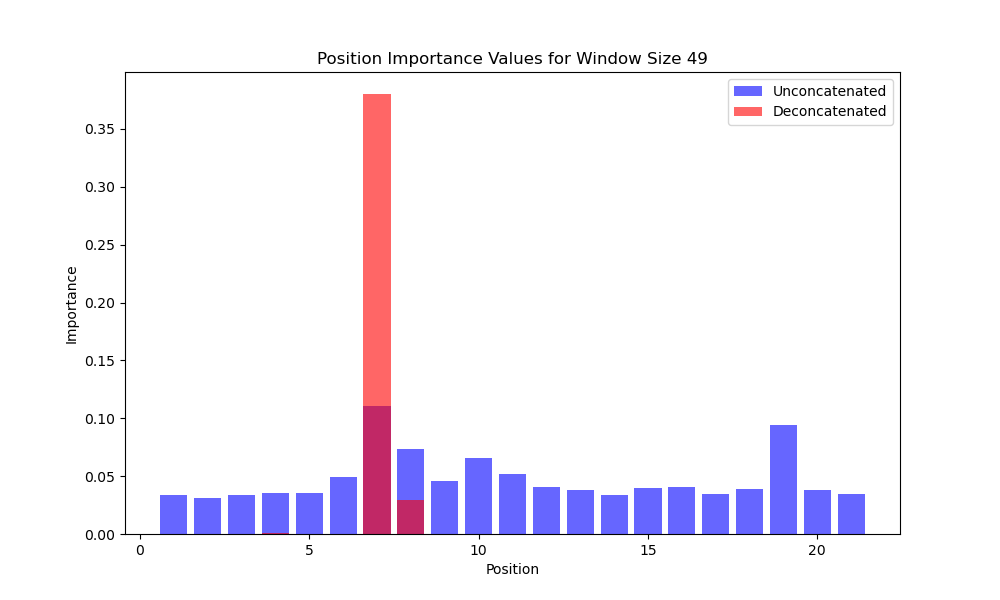

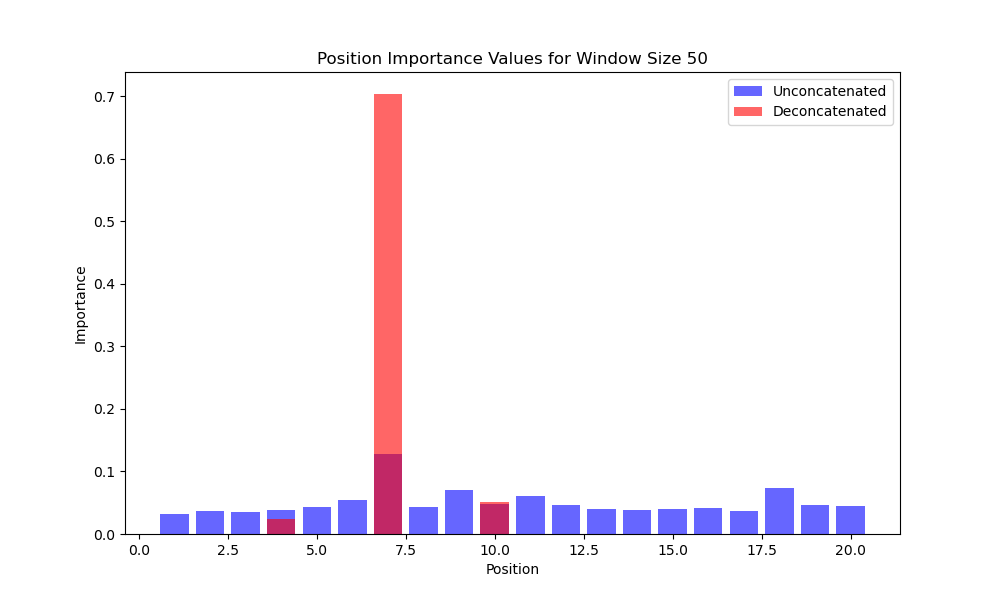

In [16]:
from IPython.display import Image, display
def display_feature_importance_plots(output_folder):
    for window_size in range(2,51):
        image_path = f"{output_folder}/Overlaid_Importance_{window_size}.png"
        display(Image(filename=image_path))
        
display_feature_importance_plots('Overlaid_Importance')